# 04: Active Learning for Intelligent Experiment Selection

**ProToPhen: Protein-to-Phenotype Foundation Model**

This notebook demonstrates how to use active learning to intelligently select
the next proteins to test experimentally. Active learning is crucial for efficient
exploration of the vast protein design space, allowing us to maximise information
gain while minimising costly wet-lab experiments.

**Contents**

1. [Introduction](#1-introduction)
2. [Model Loading](#2-model-loading)
3. [Uncertainty Quantification](#3-uncertainty-quantification)
4. [Uncertainty Analysis](#4-uncertainty-analysis)
5. [Acquisition Functions](#5-acquisition-functions)
6. [Experiment Selection](#6-experiment-selection)
7. [Simulating Active Learning Loop](#7-simulating-active-learning-loop)
8. [Model Interpretation](#8-model-interpretation)
9. [Visualisation](#9-visualisation)
10. [Practical Considerations](#10-practical-considerations)
11. [Summary & Conclusions](#11-summary--conclusion)


## Overview

In this notebook, we will:

1. **Understand Active Learning** - Why it matters for protein design
2. **Quantify Uncertainty** - MC Dropout, ensembles, and heteroscedastic methods
3. **Apply Acquisition Functions** - Strategies for selecting informative samples
4. **Select Experiments** - Use the `ExperimentSelector` for batch selection
5. **Simulate an AL Loop** - Watch model performance improve iteratively
6. **Interpret Selections** - Understand *why* proteins were selected
7. **Visualise Results** - Uncertainty distributions and embedding spaces

---

## 1. Introduction

### 1.1 Why Active Learning for Protein Design?

De novo protein design presents a fundamental challenge: the space of possible
proteins is astronomically large (20^100 for a 100-residue protein), yet each
experimental validation is expensive and time-consuming. Traditional approaches
either:

- **Random sampling**: Inefficient, may miss interesting regions
- **Exhaustive screening**: Impossible at scale
- **Expert intuition**: Biased, not scalable

**Active learning** provides a principled framework for selecting the most
informative experiments, balancing:

- **Exploration**: Testing proteins in uncertain regions of the prediction space
- **Exploitation**: Focusing on proteins predicted to have desirable properties

### 1.2 The Explore-Exploit Trade-off

```
                    High Uncertainty
                          │
             ┌────────────┼────────────┐
             │            │            │
             │  EXPLORE   │  EXPLORE   │
             │  (unknown) │  + EXPLOIT │
             │            │            │
Low Value ───┼────────────┼────────────┼─── High Value
             │            │            │
             │   IGNORE   │  EXPLOIT   │
             │            │  (greedy)  │
             │            │            │
             └────────────┼────────────┘
                          │
                    Low Uncertainty
```

Different acquisition functions navigate this trade-off differently:
- **Uncertainty Sampling**: Pure exploration
- **Expected Improvement**: Balanced exploration-exploitation
- **Diversity Sampling**: Coverage of the design space
- **Hybrid Methods**: Combine multiple objectives

### 1.3 Active Learning Loop Overview

```
┌─────────────────────────────────────────────────────────────┐
│                    ACTIVE LEARNING LOOP                     │
│                                                             │
│   ┌──────────┐    ┌──────────┐    ┌──────────┐              │
│   │  Train   │───▶│  Select  │───▶│   Label  │             │
│   │  Model   │    │  Samples │    │  (Expt)  │              │
│   └──────────┘    └──────────┘    └──────────┘              │
│        ▲                               │                    │
│        │                               │                    │
│        └───────────────────────────────┘                    │
│                                                             │
│   Iteration 1 → Iteration 2 → ... → Convergence             │
└─────────────────────────────────────────────────────────────┘
```

In [1]:
# =============================================================================
# 2. Setup
# =============================================================================

# Standard library imports
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from typing import Dict, List, Optional, Tuple
import json

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cdist

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure plotting
sns.set_style("whitegrid")
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# ProToPhen imports
from protophen.models.protophen import (
    ProToPhenModel,
    ProToPhenConfig,
    create_protophen_model,
)
from protophen.data.dataset import (
    ProtoPhenDataset,
    ProteinInferenceDataset,
    DatasetConfig,
    ProtoPhenSample,
)
from protophen.data.loaders import (
    create_dataloader,
    create_dataloaders,
)
from protophen.active_learning.uncertainty import (
    UncertaintyEstimate,
    UncertaintyType,
    MCDropoutEstimator,
    EnsembleEstimator,
    HeteroscedasticEstimator,
    estimate_uncertainty,
    get_uncertainty_ranking,
)
from protophen.active_learning.acquisition import (
    AcquisitionFunction,
    UncertaintySampling,
    ExpectedImprovement,
    ProbabilityOfImprovement,
    DiversitySampling,
    HybridAcquisition,
    BatchAcquisition,
    compute_acquisition_scores,
)
from protophen.active_learning.selection import (
    SelectionConfig,
    SelectionResult,
    ExperimentSelector,
    ActiveLearningLoop,
    select_next_experiments,
    rank_by_uncertainty,
    select_diverse_subset,
)
from protophen.analysis.interpretation import (
    GradientInterpreter,
    IntegratedGradientsInterpreter,
    FeatureAblationInterpreter,
    ModelInterpreter,
    compute_feature_importance,
    get_embedding_contribution,
)
from protophen.analysis.visualisation import (
    plot_embedding_space,
    plot_uncertainty_distribution,
    plot_active_learning_progress,
    plot_heatmap,
    save_figure,
    PlotConfig,
)
from protophen.analysis.clustering import (
    PhenotypeClustering,
    cluster_phenotypes,
    ClusteringResult,
)

print("ProToPhen modules imported successfully")

ProToPhen modules imported successfully


In [3]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
  GPU: NVIDIA RTX 2000 Ada Generation Laptop GPU
  Memory: 8.6 GB


In [4]:
# Add output directories section:
OUTPUT_DIR = Path("outputs/04_active_learning")
FIGURES_DIR = OUTPUT_DIR / "figures"
DATA_DIR = OUTPUT_DIR / "results"

for dir_path in [FIGURES_DIR, DATA_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

## 2. Model Loading 

### 2.1 Load Trained Model

We'll load the model trained in Notebook 3. For this demonstration, we'll
create a model and simulate training if the checkpoint isn't available.

In [5]:
# Configuration matching Notebook 3
PROTEIN_EMBEDDING_DIM = 1280 + 439  # ESM-2 (1280) + Physicochemical (439)
CELL_PAINTING_DIM = 1500
LATENT_DIM = 256

# Model configuration
model_config = ProToPhenConfig(
    protein_embedding_dim=PROTEIN_EMBEDDING_DIM,
    encoder_hidden_dims=[1024, 512],
    encoder_output_dim=LATENT_DIM,
    decoder_hidden_dims=[512, 1024],
    cell_painting_dim=CELL_PAINTING_DIM,
    predict_viability=True,
    mc_dropout=True,  # Enable MC Dropout for uncertainty
    encoder_dropout=0.1,
    decoder_dropout=0.1,
)

# Create model
model = ProToPhenModel(model_config)
model = model.to(device)

print(f"Model created: {model}")
print(f"\nModel summary:")
for key, value in model.summary().items():
    print(f"  {key}: {value}")

2026-02-15 23:36:31 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Model created: ProToPhenModel(input_dim=1719, latent_dim=256, tasks=[cell_painting:1500, viability:1], params=4,660,061)

Model summary:
  n_parameters: 4660061
  n_trainable_parameters: 4660061
  protein_embedding_dim: 1719
  latent_dim: 256
  tasks: {'cell_painting': 1500, 'viability': 1}
  encoder_hidden_dims: [1024, 512]
  decoder_hidden_dims: [512, 1024]


In [6]:
# Try to load pre-trained weights, or use randomly initialised model for demo
MODEL_PATH = Path("outputs/03_model_training/checkpoints/protophen_demo/final_model.pt")

if MODEL_PATH.exists():
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"   Loaded model from {MODEL_PATH}")
else:
    print("  No checkpoint found - using randomly initialised model for demonstration")
    print("  In practice, load your trained model from Notebook 3")

model.eval()

   Loaded model from outputs\03_model_training\checkpoints\protophen_demo\final_model.pt


ProToPhenModel(input_dim=1719, latent_dim=256, tasks=[cell_painting:1500, viability:1], params=4,660,061)

### 2.2 Generate Synthetic Data for Demonstration

We'll create synthetic data to demonstrate the active learning pipeline.
In practice, you would load your actual protein embeddings and experimental data.

In [7]:
def generate_synthetic_data(
    n_train: int = 100,
    n_pool: int = 500,
    embedding_dim: int = PROTEIN_EMBEDDING_DIM,
    phenotype_dim: int = CELL_PAINTING_DIM,
    n_clusters: int = 5,
    noise_level: float = 0.1,
    seed: int = 42,
) -> Tuple[Dict, Dict, np.ndarray]:
    """
    Generate synthetic protein-phenotype data for demonstration.
    
    Creates data with cluster structure to simulate different protein families
    having different phenotypic effects.
    """
    np.random.seed(seed)
    
    # Generate cluster centers in embedding space
    cluster_centers_emb = np.random.randn(n_clusters, embedding_dim) * 2
    
    # Generate cluster centers in phenotype space (mapping)
    cluster_centers_phen = np.random.randn(n_clusters, phenotype_dim)
    
    def generate_samples(n_samples, prefix="protein"):
        """Generate samples distributed across clusters."""
        # Assign samples to clusters
        cluster_assignments = np.random.randint(0, n_clusters, n_samples)
        
        # Generate embeddings around cluster centers
        embeddings = np.zeros((n_samples, embedding_dim))
        phenotypes = np.zeros((n_samples, phenotype_dim))
        
        for i in range(n_samples):
            cluster = cluster_assignments[i]
            # Embedding with cluster-specific variation
            embeddings[i] = cluster_centers_emb[cluster] + np.random.randn(embedding_dim) * 0.5
            # Phenotype with noise
            phenotypes[i] = cluster_centers_phen[cluster] + np.random.randn(phenotype_dim) * noise_level
        
        # Create sample IDs
        ids = [f"{prefix}_{i:04d}" for i in range(n_samples)]
        
        return {
            "embeddings": embeddings.astype(np.float32),
            "phenotypes": phenotypes.astype(np.float32),
            "ids": ids,
            "clusters": cluster_assignments,
        }
    
    # Generate training data (labeled)
    train_data = generate_samples(n_train, prefix="train")
    
    # Generate pool data (unlabeled candidates)
    pool_data = generate_samples(n_pool, prefix="pool")
    
    # Ground truth function for "labeling" in simulation
    # This simulates what we'd get from wet-lab experiments
    ground_truth_mapping = np.random.randn(embedding_dim, phenotype_dim) * 0.1
    
    return train_data, pool_data, ground_truth_mapping


# Generate data
train_data, pool_data, ground_truth = generate_synthetic_data()

print("Generated synthetic data:")
print(f"  Training samples: {len(train_data['ids'])}")
print(f"  Pool (candidate) samples: {len(pool_data['ids'])}")
print(f"  Embedding dimension: {train_data['embeddings'].shape[1]}")
print(f"  Phenotype dimension: {train_data['phenotypes'].shape[1]}")

Generated synthetic data:
  Training samples: 100
  Pool (candidate) samples: 500
  Embedding dimension: 1719
  Phenotype dimension: 1500


In [8]:
# Create PyTorch datasets
train_samples = [
    ProtoPhenSample(
        protein_id=train_data["ids"][i],
        protein_embedding=train_data["embeddings"][i],
        phenotypes={"cell_painting": train_data["phenotypes"][i]},
        metadata={"cluster": int(train_data["clusters"][i])},
    )
    for i in range(len(train_data["ids"]))
]

train_dataset = ProtoPhenDataset(samples=train_samples)
print(f"Training dataset: {train_dataset}")

# Create pool dataset (for inference - no labels)
pool_inference_dataset = ProteinInferenceDataset(
    protein_embeddings=pool_data["embeddings"],
    protein_ids=pool_data["ids"],
    protein_names=pool_data["ids"],  # Use IDs as names for simplicity
)
print(f"Pool dataset: {pool_inference_dataset}")

# Create DataLoaders
train_loader = create_dataloader(train_dataset, batch_size=32, shuffle=True)
pool_loader = create_dataloader(pool_inference_dataset, batch_size=32, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Pool: {len(pool_loader)} batches")

Training dataset: ProtoPhenDataset(n_samples=100, embedding_dim=1719, tasks=['cell_painting'])
Pool dataset: ProteinInferenceDataset(n_proteins=500, embedding_dim=1719)

DataLoaders created:
  Train: 4 batches
  Pool: 16 batches


## 3. Uncertainty Quantification

Uncertainty quantification is fundamental to active learning. We need to know
*where* our model is uncertain to prioritise those regions for exploration.

### 3.1 Types of Uncertainty

| Type | Description | Source | Reducible? |
|------|-------------|--------|------------|
| **Epistemic** | Model uncertainty | Limited training data | Yes (with more data) |
| **Aleatoric** | Data uncertainty | Inherent noise in measurements | No |
| **Total** | Combined uncertainty | Both sources | Partially |

For active learning, we primarily care about **epistemic uncertainty** - regions
where more data would help the model learn better.

In [9]:
# Demonstrate the UncertaintyType enum
print("Available uncertainty types:")
for unc_type in UncertaintyType:
    print(f"  - {unc_type.value}: {unc_type.name}")

Available uncertainty types:
  - epistemic: EPISTEMIC
  - aleatoric: ALEATORIC
  - total: TOTAL


### 3.2 MC Dropout Estimation

Monte Carlo Dropout is a simple yet effective method for uncertainty estimation.
By keeping dropout enabled during inference and running multiple forward passes,
we can estimate epistemic uncertainty through the variance of predictions.

**Key idea**: Different dropout masks → different predictions → variance ≈ uncertainty

In [10]:
# Create MC Dropout estimator
mc_estimator = MCDropoutEstimator(
    n_samples=20,  # Number of forward passes
    tasks=["cell_painting"],
    device=str(device),
)

print("MC Dropout Estimator Configuration:")
print(f"  Number of MC samples: {mc_estimator.n_samples}")
print(f"  Tasks: {mc_estimator.tasks}")

MC Dropout Estimator Configuration:
  Number of MC samples: 20
  Tasks: ['cell_painting']


In [11]:
# Estimate uncertainty for the pool
print("Estimating uncertainty with MC Dropout...")
mc_uncertainty = mc_estimator.estimate(
    model=model,
    dataloader=pool_loader,
    show_progress=True,
    return_samples=True,  # Keep all MC samples for analysis
)

print(f"\nUncertainty estimation complete:")
print(f"  Number of samples: {mc_uncertainty.n_samples}")
print(f"  Number of features: {mc_uncertainty.n_features}")
print(f"  Mean prediction shape: {mc_uncertainty.mean.shape}")
print(f"  Epistemic uncertainty shape: {mc_uncertainty.epistemic.shape}")
if mc_uncertainty.samples is not None:
    print(f"  MC samples shape: {mc_uncertainty.samples.shape}")

Estimating uncertainty with MC Dropout...


MC Dropout:   0%|          | 0/20 [00:00<?, ?it/s]


Uncertainty estimation complete:
  Number of samples: 500
  Number of features: 1500
  Mean prediction shape: (500, 1500)
  Epistemic uncertainty shape: (500, 1500)
  MC samples shape: (20, 500, 1500)


In [12]:
# Examine the uncertainty estimates
epistemic_per_sample = mc_uncertainty.get_uncertainty(
    uncertainty_type=UncertaintyType.EPISTEMIC,
    reduction="mean",  # Average across phenotype features
)

print("Epistemic uncertainty statistics:")
print(f"  Min: {epistemic_per_sample.min():.4f}")
print(f"  Max: {epistemic_per_sample.max():.4f}")
print(f"  Mean: {epistemic_per_sample.mean():.4f}")
print(f"  Std: {epistemic_per_sample.std():.4f}")

Epistemic uncertainty statistics:
  Min: 0.1328
  Max: 0.1512
  Mean: 0.1426
  Std: 0.0032


2026-02-15 23:36:49 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\MC_dropout_predictions.png


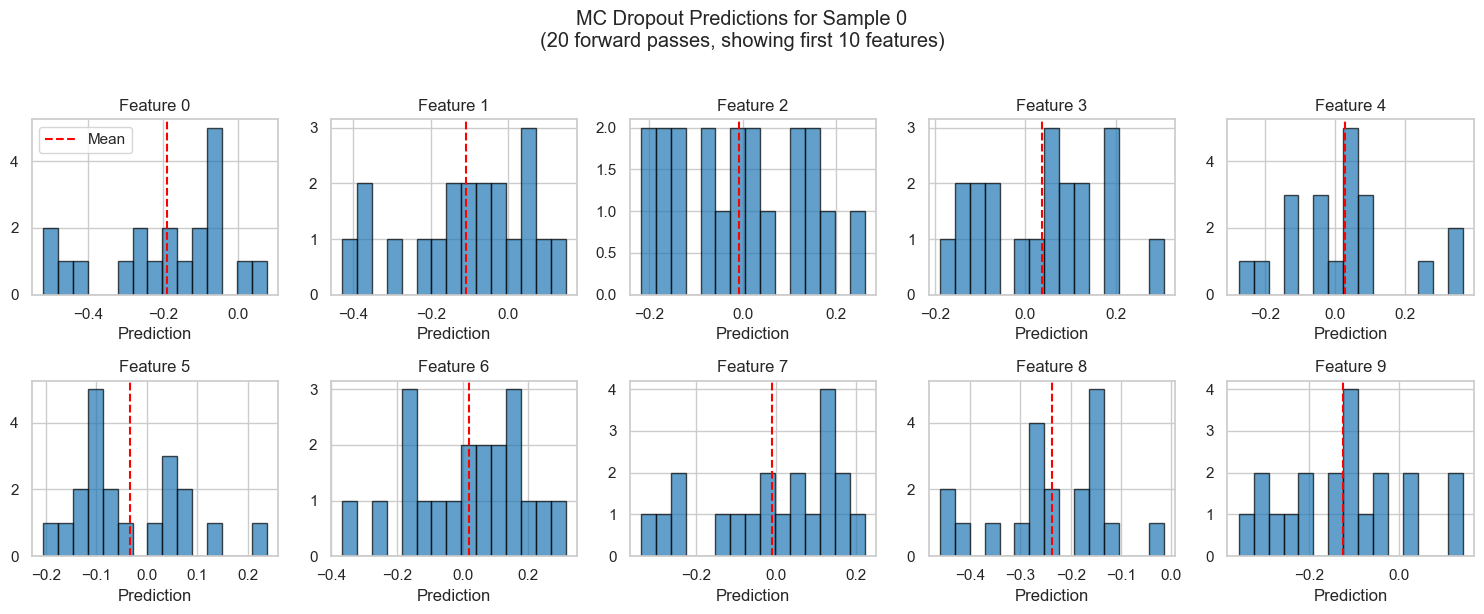

In [13]:
# Visualise MC Dropout predictions for a single sample
sample_idx = 0
if mc_uncertainty.samples is not None:
    mc_samples = mc_uncertainty.samples[:, sample_idx, :10]  # First 10 features
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.hist(mc_samples[:, i], bins=15, alpha=0.7, edgecolor='black')
        ax.axvline(mc_uncertainty.mean[sample_idx, i], color='red', 
                   linestyle='--', label='Mean')
        ax.set_title(f"Feature {i}")
        ax.set_xlabel("Prediction")
        if i == 0:
            ax.legend()
    
    plt.suptitle(f"MC Dropout Predictions for Sample {sample_idx}\n"
                 f"(20 forward passes, showing first 10 features)", y=1.02)
    plt.tight_layout()
    save_figure(fig, FIGURES_DIR / "MC_dropout_predictions.png")
    plt.show()

### 3.3 Ensemble Estimation

Deep ensembles use multiple models trained with different random seeds.
The disagreement between ensemble members indicates uncertainty.

**Advantages over MC Dropout:**
- Often better calibrated
- Each member can learn different aspects

**Disadvantages:**
- Requires training multiple models
- Higher computational cost

In [14]:
# Create a small ensemble for demonstration
print("Creating model ensemble...")
n_ensemble = 3
ensemble_models = []

for i in range(n_ensemble):
    # Create model with different random initialisation
    torch.manual_seed(42 + i)
    ensemble_model = ProToPhenModel(model_config)
    ensemble_model = ensemble_model.to(device)
    ensemble_model.eval()
    ensemble_models.append(ensemble_model)
    
print(f"Created ensemble with {n_ensemble} models")

2026-02-15 23:36:49 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']
2026-02-15 23:36:49 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']
2026-02-15 23:36:49 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Creating model ensemble...
Created ensemble with 3 models


In [15]:
# Estimate uncertainty using ensemble
ensemble_estimator = EnsembleEstimator(
    tasks=["cell_painting"],
    device=str(device),
)

print("Estimating uncertainty with ensemble...")
ensemble_uncertainty = ensemble_estimator.estimate(
    model=ensemble_models,
    dataloader=pool_loader,
    show_progress=True,
)

print(f"\nEnsemble uncertainty estimation complete:")
print(f"  Epistemic uncertainty shape: {ensemble_uncertainty.epistemic.shape}")

# Compare with MC Dropout
ensemble_epistemic = ensemble_uncertainty.get_uncertainty(
    uncertainty_type=UncertaintyType.EPISTEMIC,
    reduction="mean",
)

print(f"\nComparison of uncertainty methods:")
print(f"  MC Dropout - Mean epistemic: {epistemic_per_sample.mean():.4f}")
print(f"  Ensemble   - Mean epistemic: {ensemble_epistemic.mean():.4f}")

Estimating uncertainty with ensemble...


Ensemble:   0%|          | 0/3 [00:00<?, ?it/s]


Ensemble uncertainty estimation complete:
  Epistemic uncertainty shape: (500, 1500)

Comparison of uncertainty methods:
  MC Dropout - Mean epistemic: 0.1426
  Ensemble   - Mean epistemic: 0.2728


### 3.4 Heteroscedastic Estimation (Aleatoric Uncertainty)

If your model predicts both mean and variance (heteroscedastic), you can
estimate aleatoric (data) uncertainty directly from the predicted variance.

Combined with MC Dropout, this gives both uncertainty types:
- **Epistemic**: From MC sample variance
- **Aleatoric**: From predicted variance
- **Total**: √(epistemic² + aleatoric²)

In [16]:
# Note: This requires a model that predicts variance
# For demonstration, we'll show the API

print("Heteroscedastic uncertainty estimation:")
print("  Requires model with predict_uncertainty=True")
print("  Model predicts: (mean, log_variance)")
print("  Aleatoric uncertainty = sqrt(exp(log_variance))")
print("\nExample configuration:")

hetero_config = ProToPhenConfig(
    protein_embedding_dim=PROTEIN_EMBEDDING_DIM,
    cell_painting_dim=CELL_PAINTING_DIM,
    predict_uncertainty=True,  # Enable variance prediction
)
print(f"  predict_uncertainty: {hetero_config.predict_uncertainty}")

Heteroscedastic uncertainty estimation:
  Requires model with predict_uncertainty=True
  Model predicts: (mean, log_variance)
  Aleatoric uncertainty = sqrt(exp(log_variance))

Example configuration:
  predict_uncertainty: True


In [17]:
# Convenience function for uncertainty estimation
print("Using convenience function estimate_uncertainty()...")

quick_uncertainty = estimate_uncertainty(
    model=model,
    dataloader=pool_loader,
    method="mc_dropout",
    n_samples=10,  # Fewer samples for quick estimation
    tasks=["cell_painting"],
    show_progress=True,
)

print(f"Quick uncertainty estimation complete:")
print(f"  Shape: {quick_uncertainty.total.shape}")

Using convenience function estimate_uncertainty()...


MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

Quick uncertainty estimation complete:
  Shape: (500, 1500)


### 3.5 Visualising Uncertainty

Let's visualise the uncertainty distribution across our candidate pool.

2026-02-15 23:36:50 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\uncertainty_distribution.png


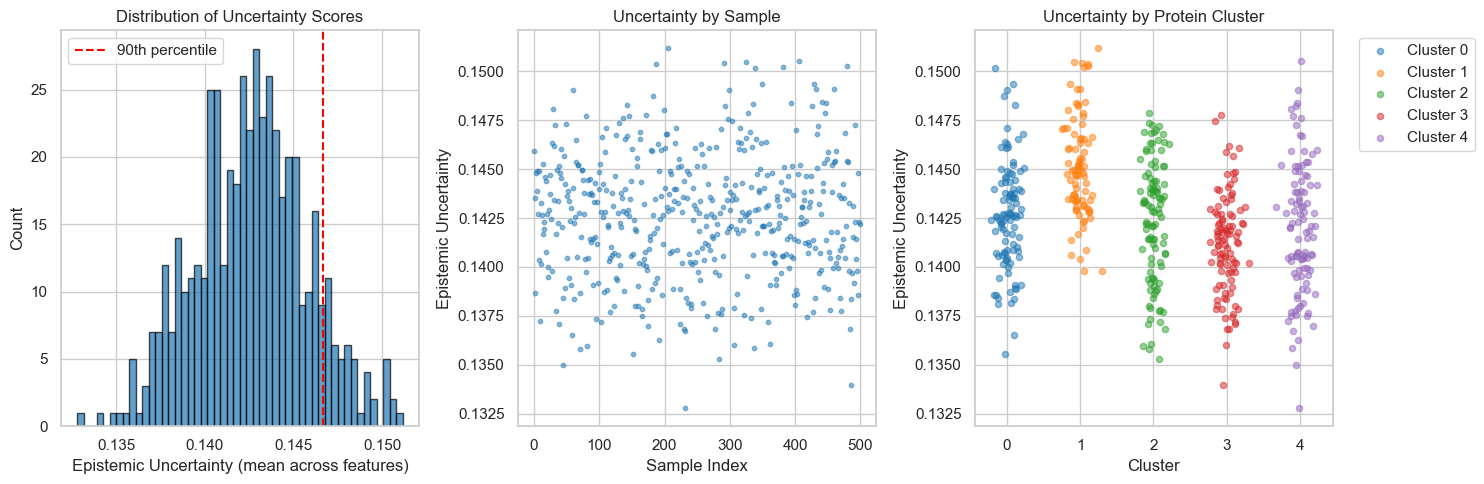

In [18]:
# Plot uncertainty distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Histogram of uncertainty scores
ax = axes[0]
ax.hist(epistemic_per_sample, bins=50, alpha=0.7, edgecolor='black')
ax.set_xlabel("Epistemic Uncertainty (mean across features)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Uncertainty Scores")
ax.axvline(np.percentile(epistemic_per_sample, 90), color='red', 
           linestyle='--', label='90th percentile')
ax.legend()

# 2. Uncertainty vs sample index (to check for patterns)
ax = axes[1]
ax.scatter(range(len(epistemic_per_sample)), epistemic_per_sample, alpha=0.5, s=10)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Epistemic Uncertainty")
ax.set_title("Uncertainty by Sample")

# 3. Uncertainty by cluster (using ground truth clusters)
ax = axes[2]
clusters = pool_data["clusters"]
for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    cluster_unc = epistemic_per_sample[mask]
    ax.scatter(
        np.random.normal(cluster_id, 0.1, len(cluster_unc)),
        cluster_unc,
        alpha=0.5,
        label=f"Cluster {cluster_id}",
        s=20,
    )
ax.set_xlabel("Cluster")
ax.set_ylabel("Epistemic Uncertainty")
ax.set_title("Uncertainty by Protein Cluster")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "uncertainty_distribution.png")
plt.show()

## 4. Uncertainty Analysis

Now let's dive deeper into understanding and using uncertainty estimates.

### 4.1 The UncertaintyEstimate Object

In [19]:
# Examine the UncertaintyEstimate object
print("UncertaintyEstimate attributes:")
print(f"  mean: Predictions averaged over MC samples - shape {mc_uncertainty.mean.shape}")
print(f"  epistemic: Model uncertainty - shape {mc_uncertainty.epistemic.shape}")
print(f"  aleatoric: Data uncertainty - {mc_uncertainty.aleatoric}")
print(f"  total: Combined uncertainty - shape {mc_uncertainty.total.shape}")
print(f"  sample_ids: {mc_uncertainty.sample_ids[:5] if mc_uncertainty.sample_ids else None}...")

UncertaintyEstimate attributes:
  mean: Predictions averaged over MC samples - shape (500, 1500)
  epistemic: Model uncertainty - shape (500, 1500)
  aleatoric: Data uncertainty - None
  total: Combined uncertainty - shape (500, 1500)
  sample_ids: ['pool_0000', 'pool_0001', 'pool_0002', 'pool_0003', 'pool_0004']...


In [20]:
# Convert to dictionary for storage
uncertainty_dict = mc_uncertainty.to_dict()
print("Uncertainty estimate as dictionary:")
for key, value in uncertainty_dict.items():
    if isinstance(value, np.ndarray):
        print(f"  {key}: array of shape {value.shape}")
    elif isinstance(value, list):
        print(f"  {key}: list of length {len(value)}")
    else:
        print(f"  {key}: {value}")

Uncertainty estimate as dictionary:
  mean: array of shape (500, 1500)
  epistemic: array of shape (500, 1500)
  aleatoric: None
  total: array of shape (500, 1500)
  sample_ids: list of length 500


### 4.2 Aggregation Methods

Uncertainty is computed per-feature. We need to aggregate across features
to get a single score per sample for ranking.

2026-02-15 23:36:51 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\aggregation_method_uncertainty.png


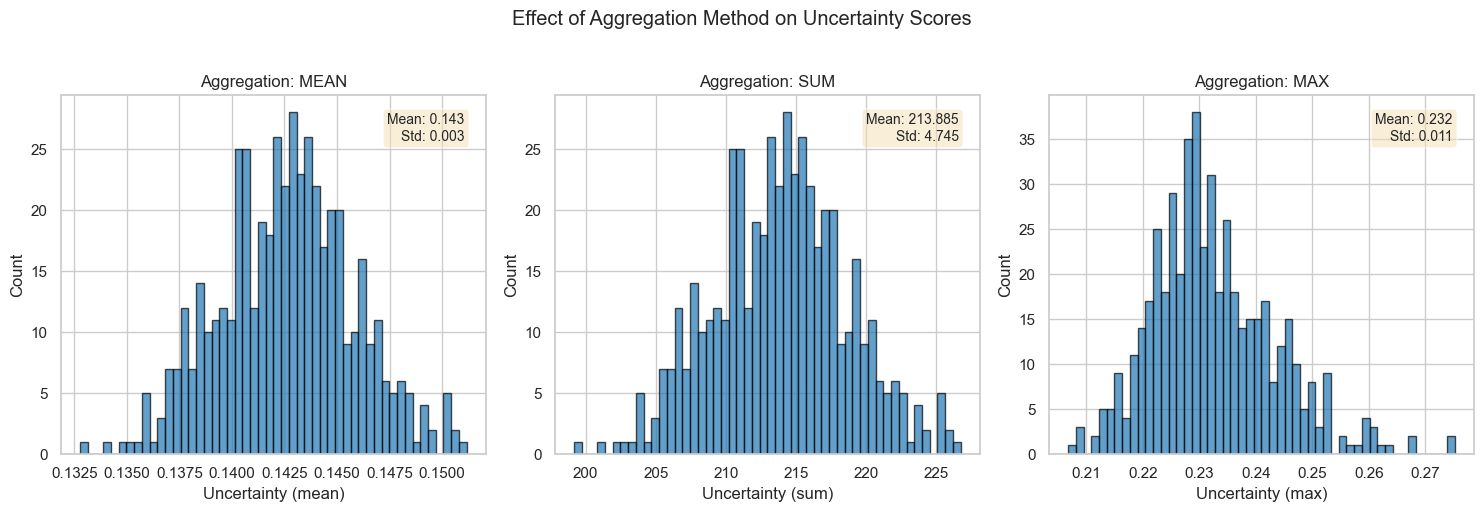

In [21]:
# Compare different aggregation methods
aggregation_methods = ["mean", "sum", "max"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, method in zip(axes, aggregation_methods):
    scores = mc_uncertainty.get_uncertainty(
        uncertainty_type=UncertaintyType.EPISTEMIC,
        reduction=method,
    )
    ax.hist(scores, bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel(f"Uncertainty ({method})")
    ax.set_ylabel("Count")
    ax.set_title(f"Aggregation: {method.upper()}")
    
    # Show statistics
    textstr = f'Mean: {scores.mean():.3f}\nStd: {scores.std():.3f}'
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle("Effect of Aggregation Method on Uncertainty Scores", y=1.02)
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "aggregation_method_uncertainty.png")
plt.show()

2026-02-15 23:36:51 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\aggregation_method_correlation.png


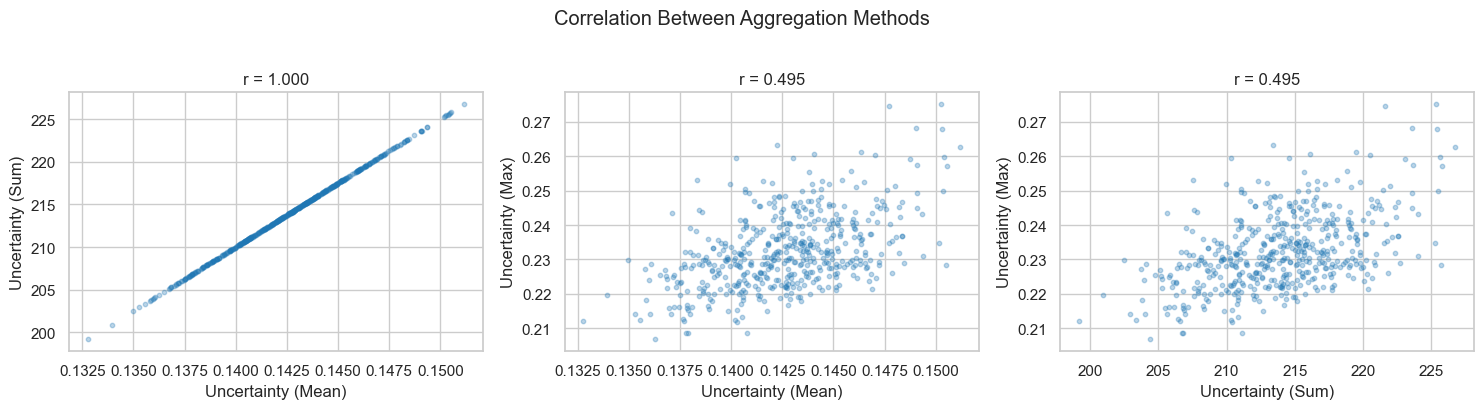

In [22]:
# Correlation between aggregation methods
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

scores_mean = mc_uncertainty.get_uncertainty(reduction="mean")
scores_sum = mc_uncertainty.get_uncertainty(reduction="sum")
scores_max = mc_uncertainty.get_uncertainty(reduction="max")

pairs = [
    (scores_mean, scores_sum, "Mean", "Sum"),
    (scores_mean, scores_max, "Mean", "Max"),
    (scores_sum, scores_max, "Sum", "Max"),
]

for ax, (s1, s2, n1, n2) in zip(axes, pairs):
    ax.scatter(s1, s2, alpha=0.3, s=10)
    r = np.corrcoef(s1, s2)[0, 1]
    ax.set_xlabel(f"Uncertainty ({n1})")
    ax.set_ylabel(f"Uncertainty ({n2})")
    ax.set_title(f"r = {r:.3f}")

plt.suptitle("Correlation Between Aggregation Methods", y=1.02)
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "aggregation_method_correlation.png")
plt.show()

### 4.3 Ranking by Uncertainty

In [23]:
# Rank samples by uncertainty
ranked_indices, ranked_scores = get_uncertainty_ranking(
    mc_uncertainty,
    uncertainty_type=UncertaintyType.TOTAL,
    reduction="mean",
    ascending=False,  # Highest uncertainty first
)

print("Top 10 most uncertain samples:")
print("-" * 50)
for i in range(10):
    sample_idx = ranked_indices[i]
    sample_id = mc_uncertainty.sample_ids[sample_idx] if mc_uncertainty.sample_ids else f"sample_{sample_idx}"
    print(f"  Rank {i+1}: {sample_id} (uncertainty: {ranked_scores[i]:.4f})")

Top 10 most uncertain samples:
--------------------------------------------------
  Rank 1: pool_0205 (uncertainty: 0.1512)
  Rank 2: pool_0406 (uncertainty: 0.1505)
  Rank 3: pool_0325 (uncertainty: 0.1505)
  Rank 4: pool_0291 (uncertainty: 0.1504)
  Rank 5: pool_0187 (uncertainty: 0.1504)
  Rank 6: pool_0479 (uncertainty: 0.1503)
  Rank 7: pool_0382 (uncertainty: 0.1502)
  Rank 8: pool_0338 (uncertainty: 0.1502)
  Rank 9: pool_0349 (uncertainty: 0.1494)
  Rank 10: pool_0429 (uncertainty: 0.1493)


2026-02-15 23:36:52 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\high_vs_low_uncertainty_pca.png


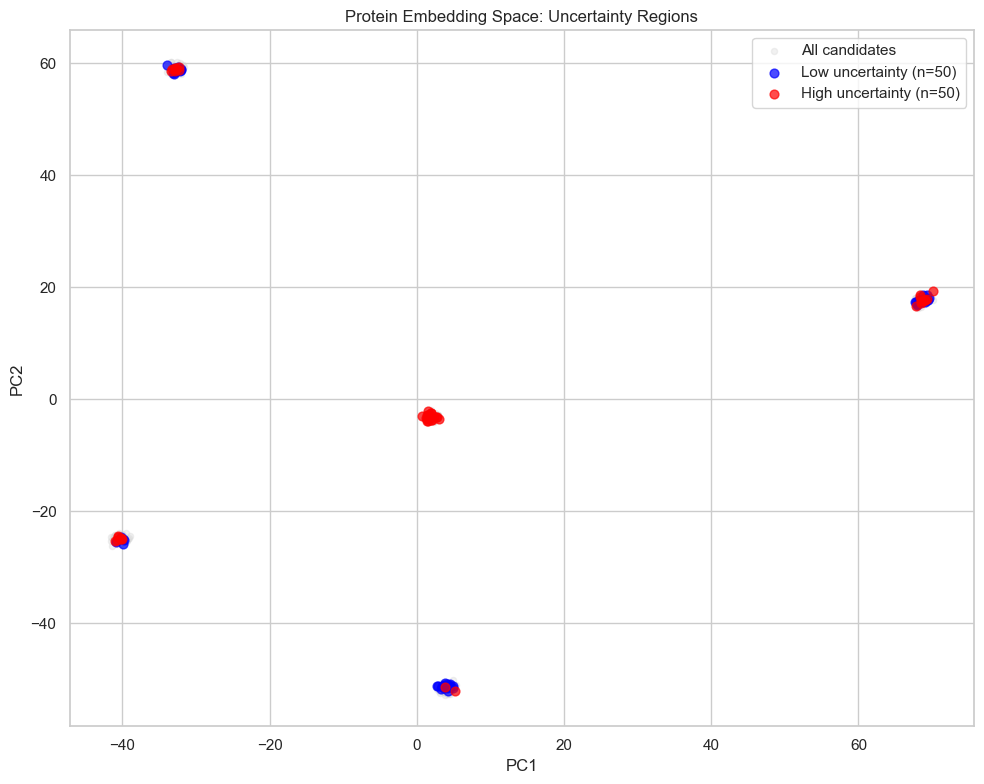

In [24]:
# Visualise top uncertain vs low uncertain samples in embedding space
n_top = 50
n_bottom = 50

top_uncertain_idx = ranked_indices[:n_top]
bottom_uncertain_idx = ranked_indices[-n_bottom:]
middle_idx = ranked_indices[len(ranked_indices)//2 - 25: len(ranked_indices)//2 + 25]

# Reduce embeddings for visualisation
from sklearn.decomposition import PCA

embeddings = pool_data["embeddings"]
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))

# Plot all points
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
            c='lightgray', alpha=0.3, s=20, label='All candidates')

# Highlight high/low uncertainty
plt.scatter(embeddings_2d[bottom_uncertain_idx, 0], embeddings_2d[bottom_uncertain_idx, 1],
            c='blue', alpha=0.7, s=40, label=f'Low uncertainty (n={n_bottom})')
plt.scatter(embeddings_2d[top_uncertain_idx, 0], embeddings_2d[top_uncertain_idx, 1],
            c='red', alpha=0.7, s=40, label=f'High uncertainty (n={n_top})')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Protein Embedding Space: Uncertainty Regions")
plt.legend()
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "high_vs_low_uncertainty_pca.png")
plt.show()

### 4.4 Identifying High-Uncertainty Regions

Let's understand what characterises high-uncertainty proteins.

In [25]:
# Analyse high vs low uncertainty samples
high_unc_embeddings = embeddings[top_uncertain_idx]
low_unc_embeddings = embeddings[bottom_uncertain_idx]

# Compare feature statistics
high_unc_mean = high_unc_embeddings.mean(axis=0)
low_unc_mean = low_unc_embeddings.mean(axis=0)

# Find most discriminative features
feature_diff = np.abs(high_unc_mean - low_unc_mean)
top_diff_features = np.argsort(feature_diff)[-20:]

print("Top 20 most discriminative embedding features (high vs low uncertainty):")
for i, feat_idx in enumerate(top_diff_features[::-1]):
    print(f"  Feature {feat_idx}: diff = {feature_diff[feat_idx]:.4f}")

Top 20 most discriminative embedding features (high vs low uncertainty):
  Feature 586: diff = 3.9773
  Feature 1176: diff = 3.4705
  Feature 513: diff = 3.2735
  Feature 1715: diff = 3.2313
  Feature 305: diff = 3.1618
  Feature 252: diff = 3.1364
  Feature 1572: diff = 3.1279
  Feature 639: diff = 3.1142
  Feature 191: diff = 3.0742
  Feature 1615: diff = 3.0313
  Feature 837: diff = 3.0156
  Feature 752: diff = 2.9277
  Feature 1585: diff = 2.8564
  Feature 1361: diff = 2.8304
  Feature 307: diff = 2.8289
  Feature 418: diff = 2.8234
  Feature 232: diff = 2.8007
  Feature 316: diff = 2.7975
  Feature 1654: diff = 2.7789
  Feature 1675: diff = 2.7680


In [26]:
# Cluster the high-uncertainty samples
print("Clustering high-uncertainty samples...")

high_unc_clustering = cluster_phenotypes(
    high_unc_embeddings,
    method="kmeans",
    n_clusters=3,
    sample_ids=[mc_uncertainty.sample_ids[i] for i in top_uncertain_idx] 
               if mc_uncertainty.sample_ids else None,
)

print(high_unc_clustering.summary())

Clustering high-uncertainty samples...


2026-02-15 23:36:56 | INFO     | protophen.analysis.clustering:fit:411 | Clustering Result (kmeans)
  N clusters: 3
  Cluster sizes: {0: 9, 1: 31, 2: 10}
  Silhouette score: 0.4830
  Calinski-Harabasz: 26.21
  Davies-Bouldin: 0.8128


Clustering Result (kmeans)
  N clusters: 3
  Cluster sizes: {0: 9, 1: 31, 2: 10}
  Silhouette score: 0.4830
  Calinski-Harabasz: 26.21
  Davies-Bouldin: 0.8128


## 5. Acquisition Functions

Acquisition functions score samples for selection. Different functions
embody different exploration-exploitation strategies.

### 5.1 Uncertainty Sampling

The simplest approach: select samples where the model is most uncertain.

In [27]:
# Create uncertainty sampling acquisition function
uncertainty_acq = UncertaintySampling(
    uncertainty_type=UncertaintyType.EPISTEMIC,
    reduction="mean",
)

# Score all samples
uncertainty_scores = uncertainty_acq.score(mc_uncertainty)

# Select top samples
n_select = 20
uncertainty_selected = uncertainty_acq.select(mc_uncertainty, n_select=n_select)

print(f"Uncertainty Sampling - Selected {len(uncertainty_selected)} samples")
print(f"Selected indices: {uncertainty_selected[:10]}...")
print(f"Score range: {uncertainty_scores[uncertainty_selected].min():.4f} - "
      f"{uncertainty_scores[uncertainty_selected].max():.4f}")

Uncertainty Sampling - Selected 20 samples
Selected indices: [205 406 325 291 187 479 382 338 349 429]...
Score range: 0.1483 - 0.1512


### 5.2 Expected Improvement (EI)

EI balances exploration and exploitation by computing the expected improvement
over the current best observation.

In [28]:
# Create Expected Improvement acquisition function
ei_acq = ExpectedImprovement(
    target_feature_idx=0,  # Optimise first phenotype feature
    maximise=True,  # We want to maximise this feature
    xi=0.01,  # Exploration-exploitation trade-off
)

# Set best observed value (from training data)
best_observed = train_data["phenotypes"][:, 0].max()
ei_acq.set_best_value(best_observed)
print(f"Best observed value (feature 0): {best_observed:.4f}")

# Score samples
ei_scores = ei_acq.score(mc_uncertainty, best_value=best_observed)

# Select top samples
ei_selected = ei_acq.select(mc_uncertainty, n_select=n_select)

print(f"\nExpected Improvement - Selected {len(ei_selected)} samples")
print(f"Score range: {ei_scores[ei_selected].min():.4f} - "
      f"{ei_scores[ei_selected].max():.4f}")

Best observed value (feature 0): 1.7545

Expected Improvement - Selected 20 samples
Score range: 0.0000 - 0.0000


### 5.3 Probability of Improvement (PI)

PI computes the probability that a sample will improve upon the best observation.
Simpler than EI but can be too greedy.

In [29]:
# Create Probability of Improvement acquisition function
pi_acq = ProbabilityOfImprovement(
    target_feature_idx=0,
    maximise=True,
    xi=0.01,
)

# Score samples
pi_scores = pi_acq.score(mc_uncertainty, best_value=best_observed)

# Select top samples
pi_selected = pi_acq.select(mc_uncertainty, n_select=n_select)

print(f"Probability of Improvement - Selected {len(pi_selected)} samples")
print(f"Score range: {pi_scores[pi_selected].min():.4f} - "
      f"{pi_scores[pi_selected].max():.4f}")

Probability of Improvement - Selected 20 samples
Score range: 0.0000 - 0.0000


### 5.4 Diversity Sampling

Pure diversity sampling selects samples that are spread out in embedding space,
ensuring good coverage of the design space.

**Methods:**
- **k-means++**: Samples proportional to squared distance
- **maxmin**: Greedily maximises minimum distance
- **DPP**: Determinantal Point Process (probabilistic diversity)

In [30]:
# Create diversity sampling with different methods
methods = ["kmeans++", "maxmin"]

diversity_results = {}
for method in methods:
    div_acq = DiversitySampling(method=method, metric="euclidean")
    selected = div_acq.select(
        mc_uncertainty,
        n_select=n_select,
        embeddings=pool_data["embeddings"],
    )
    diversity_results[method] = selected
    print(f"Diversity ({method}) - Selected {len(selected)} samples")

Diversity (kmeans++) - Selected 20 samples
Diversity (maxmin) - Selected 20 samples


2026-02-15 23:36:57 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\selection_strategy_pca.png


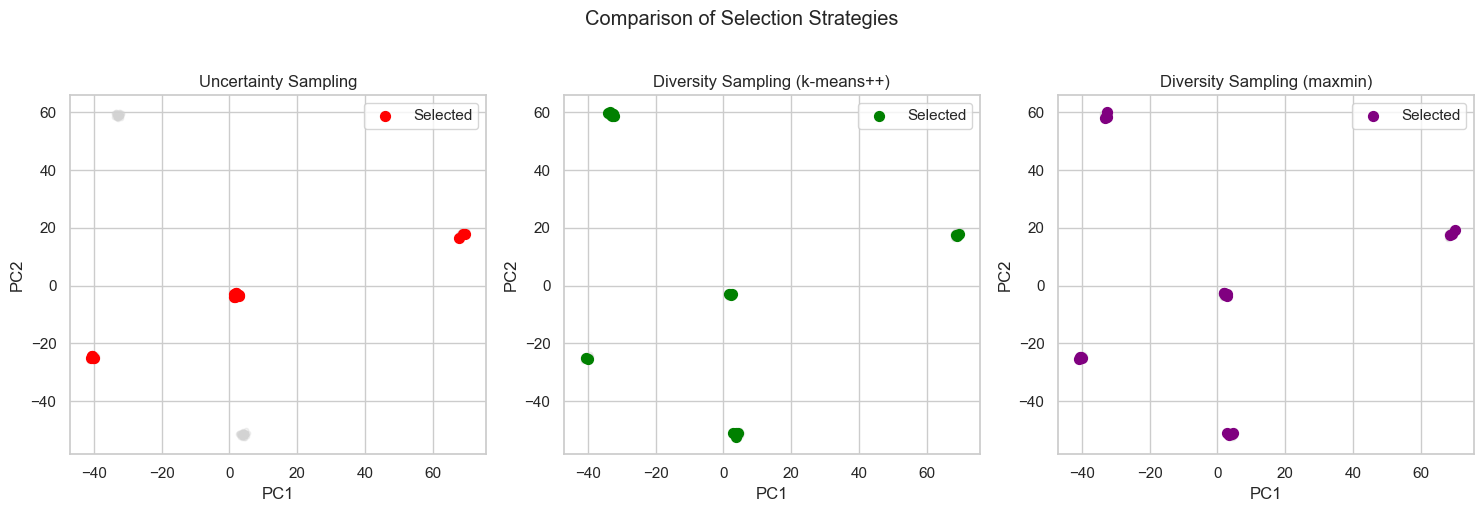

In [31]:
# Visualise diversity selection vs uncertainty selection
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Reduce to 2D for visualisation
embeddings_2d = pca.transform(pool_data["embeddings"])

# Plot 1: Uncertainty sampling
ax = axes[0]
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='lightgray', alpha=0.3, s=10)
ax.scatter(embeddings_2d[uncertainty_selected, 0], embeddings_2d[uncertainty_selected, 1],
           c='red', s=50, label='Selected')
ax.set_title("Uncertainty Sampling")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

# Plot 2: k-means++ diversity
ax = axes[1]
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='lightgray', alpha=0.3, s=10)
ax.scatter(embeddings_2d[diversity_results["kmeans++"], 0], 
           embeddings_2d[diversity_results["kmeans++"], 1],
           c='green', s=50, label='Selected')
ax.set_title("Diversity Sampling (k-means++)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

# Plot 3: maxmin diversity
ax = axes[2]
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='lightgray', alpha=0.3, s=10)
ax.scatter(embeddings_2d[diversity_results["maxmin"], 0],
           embeddings_2d[diversity_results["maxmin"], 1],
           c='purple', s=50, label='Selected')
ax.set_title("Diversity Sampling (maxmin)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

plt.suptitle("Comparison of Selection Strategies", y=1.02)
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "selection_strategy_pca.png")
plt.show()

### 5.5 Hybrid Acquisition (Uncertainty + Diversity)

The hybrid approach combines uncertainty and diversity to select samples
that are both informative AND diverse. This is often the best strategy
for batch active learning.

In [32]:
# Create hybrid acquisition function
hybrid_acq = HybridAcquisition(
    uncertainty_weight=0.7,
    diversity_weight=0.3,
    uncertainty_type=UncertaintyType.EPISTEMIC,
    diversity_method="kmeans++",
)

# Select samples
hybrid_selected = hybrid_acq.select(
    mc_uncertainty,
    n_select=n_select,
    embeddings=pool_data["embeddings"],
)

print(f"Hybrid Acquisition - Selected {len(hybrid_selected)} samples")
print(f"  Uncertainty weight: {hybrid_acq.uncertainty_weight}")
print(f"  Diversity weight: {hybrid_acq.diversity_weight}")

Hybrid Acquisition - Selected 20 samples
  Uncertainty weight: 0.7
  Diversity weight: 0.3


In [33]:
# Compare selections across strategies
print("\nOverlap analysis between selection strategies:")
print("-" * 50)

strategies = {
    "Uncertainty": set(uncertainty_selected),
    "EI": set(ei_selected),
    "Diversity (kmeans++)": set(diversity_results["kmeans++"]),
    "Hybrid": set(hybrid_selected),
}

# Create overlap matrix
strategy_names = list(strategies.keys())
overlap_matrix = np.zeros((len(strategy_names), len(strategy_names)))

for i, name1 in enumerate(strategy_names):
    for j, name2 in enumerate(strategy_names):
        overlap = len(strategies[name1] & strategies[name2])
        overlap_matrix[i, j] = overlap

print("Selection overlap (number of shared samples):")
overlap_df = pd.DataFrame(overlap_matrix, index=strategy_names, columns=strategy_names)
print(overlap_df.to_string())


Overlap analysis between selection strategies:
--------------------------------------------------
Selection overlap (number of shared samples):
                      Uncertainty    EI  Diversity (kmeans++)  Hybrid
Uncertainty                  20.0   1.0                   0.0    12.0
EI                            1.0  20.0                   1.0     2.0
Diversity (kmeans++)          0.0   1.0                  20.0     1.0
Hybrid                       12.0   2.0                   1.0    20.0


2026-02-15 23:36:57 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\selection_overlap_heatmap.png


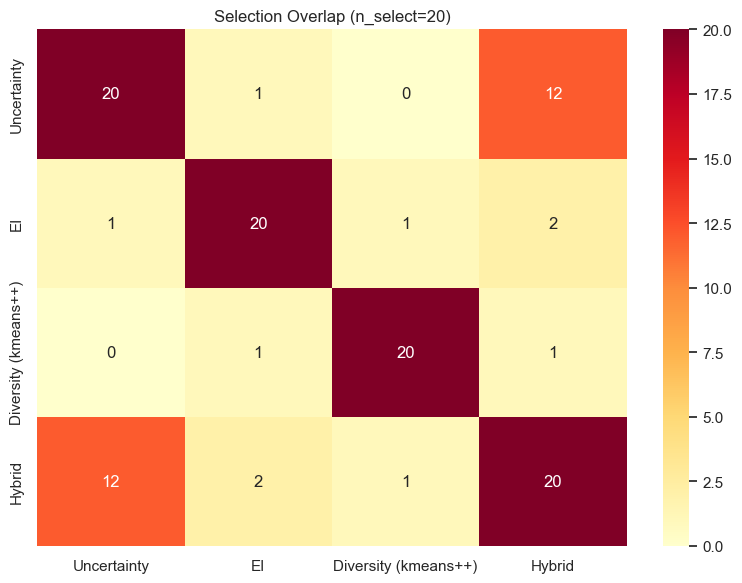

In [34]:
# Visualise overlap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(overlap_matrix, annot=True, fmt=".0f", cmap="YlOrRd",
            xticklabels=strategy_names, yticklabels=strategy_names, ax=ax)
ax.set_title(f"Selection Overlap (n_select={n_select})")
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "selection_overlap_heatmap.png")
plt.show()

### 5.6 Comparing Acquisition Strategies

Let's compare the properties of samples selected by different strategies.

In [35]:
# Analyse properties of selected samples
def analyse_selection(name, indices, embeddings, uncertainty_scores, clusters):
    """Analyse properties of selected samples."""
    selected_emb = embeddings[indices]
    selected_unc = uncertainty_scores[indices]
    selected_clusters = clusters[indices]
    
    # Compute pairwise distances (diversity measure)
    if len(indices) > 1:
        distances = cdist(selected_emb, selected_emb)
        avg_distance = distances[np.triu_indices(len(indices), k=1)].mean()
    else:
        avg_distance = 0
    
    # Cluster coverage
    cluster_coverage = len(np.unique(selected_clusters)) / len(np.unique(clusters))
    
    return {
        "name": name,
        "mean_uncertainty": selected_unc.mean(),
        "std_uncertainty": selected_unc.std(),
        "avg_pairwise_distance": avg_distance,
        "cluster_coverage": cluster_coverage,
        "n_clusters_covered": len(np.unique(selected_clusters)),
    }


# Analyse all strategies
analyses = []
all_strategies = {
    "Uncertainty": uncertainty_selected,
    "Expected Improvement": ei_selected,
    "Diversity (kmeans++)": diversity_results["kmeans++"],
    "Diversity (maxmin)": diversity_results["maxmin"],
    "Hybrid": hybrid_selected,
}

for name, indices in all_strategies.items():
    analysis = analyse_selection(
        name, indices,
        pool_data["embeddings"],
        epistemic_per_sample,
        pool_data["clusters"],
    )
    analyses.append(analysis)

analysis_df = pd.DataFrame(analyses)
analysis_df = analysis_df.set_index("name")
print("\nSelection Strategy Analysis:")
print("=" * 80)
print(analysis_df.to_string())


Selection Strategy Analysis:
                      mean_uncertainty  std_uncertainty  avg_pairwise_distance  cluster_coverage  n_clusters_covered
name                                                                                                                
Uncertainty                   0.149456         0.000891              83.314905               0.6                   3
Expected Improvement          0.144085         0.002076              80.952183               0.8                   4
Diversity (kmeans++)          0.141385         0.003264             103.605007               1.0                   5
Diversity (maxmin)            0.142402         0.003794             107.049401               1.0                   5
Hybrid                        0.149017         0.001274              95.382363               1.0                   5


2026-02-15 23:36:58 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\selection_strategy_comparison.png


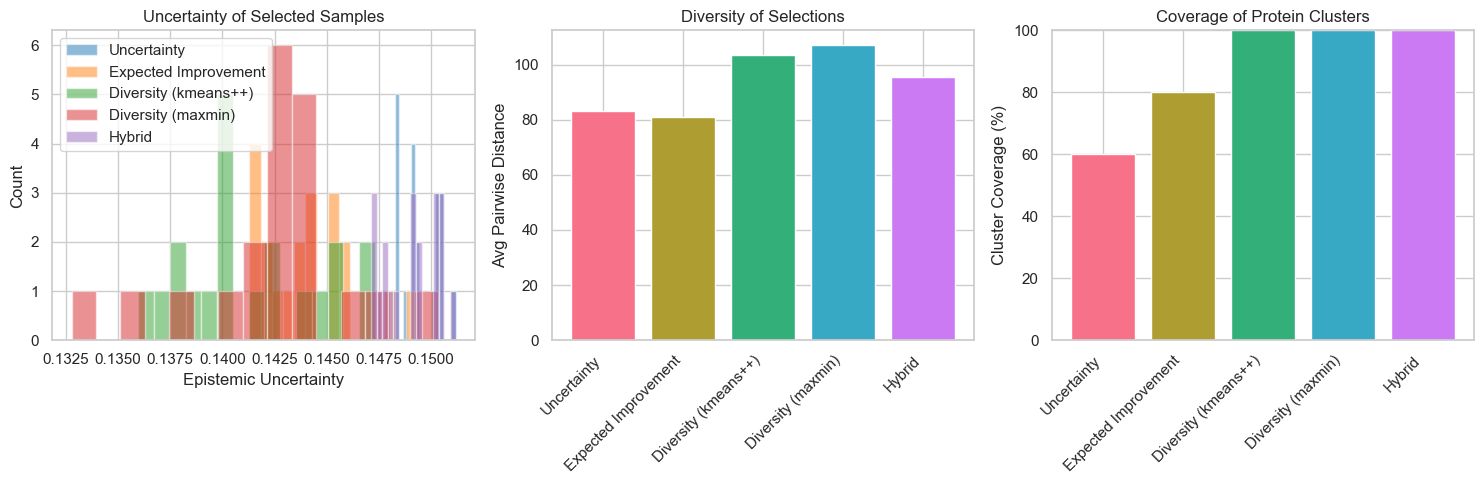

In [36]:
# Visualise strategy comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Uncertainty distribution
ax = axes[0]
for name, indices in all_strategies.items():
    selected_unc = epistemic_per_sample[indices]
    ax.hist(selected_unc, bins=15, alpha=0.5, label=name)
ax.set_xlabel("Epistemic Uncertainty")
ax.set_ylabel("Count")
ax.set_title("Uncertainty of Selected Samples")
ax.legend()

# Plot 2: Diversity (pairwise distance)
ax = axes[1]
names = list(all_strategies.keys())
distances = [analysis_df.loc[n, "avg_pairwise_distance"] for n in names]
bars = ax.bar(range(len(names)), distances, color=sns.color_palette("husl", len(names)))
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel("Avg Pairwise Distance")
ax.set_title("Diversity of Selections")

# Plot 3: Cluster coverage
ax = axes[2]
coverage = [analysis_df.loc[n, "cluster_coverage"] * 100 for n in names]
bars = ax.bar(range(len(names)), coverage, color=sns.color_palette("husl", len(names)))
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel("Cluster Coverage (%)")
ax.set_title("Coverage of Protein Clusters")
ax.set_ylim(0, 100)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "selection_strategy_comparison.png")
plt.show()

## 6. Experiment Selection

The `ExperimentSelector` class provides a high-level interface for selecting
experiments, coordinating uncertainty estimation and acquisition functions.

### 6.1 SelectionConfig Options

In [37]:
# Explore selection configuration options
print("SelectionConfig options:")
print("-" * 50)

# Create a default config
default_config = SelectionConfig()

for field_name in default_config.__dataclass_fields__:
    value = getattr(default_config, field_name)
    print(f"  {field_name}: {value}")

SelectionConfig options:
--------------------------------------------------
  n_select: 10
  uncertainty_method: mc_dropout
  n_mc_samples: 20
  acquisition_method: hybrid
  uncertainty_weight: 0.7
  diversity_weight: 0.3
  uncertainty_type: UncertaintyType.TOTAL
  exclude_ids: []
  tasks: ['cell_painting']


In [38]:
# Create a custom configuration
custom_config = SelectionConfig(
    n_select=15,
    uncertainty_method="mc_dropout",
    n_mc_samples=20,
    acquisition_method="hybrid",
    uncertainty_weight=0.6,
    diversity_weight=0.4,
    uncertainty_type=UncertaintyType.EPISTEMIC,
    tasks=["cell_painting"],
)

print("Custom SelectionConfig:")
print(f"  Batch size: {custom_config.n_select}")
print(f"  Uncertainty method: {custom_config.uncertainty_method}")
print(f"  Acquisition method: {custom_config.acquisition_method}")
print(f"  Uncertainty weight: {custom_config.uncertainty_weight}")
print(f"  Diversity weight: {custom_config.diversity_weight}")

Custom SelectionConfig:
  Batch size: 15
  Uncertainty method: mc_dropout
  Acquisition method: hybrid
  Uncertainty weight: 0.6
  Diversity weight: 0.4


### 6.2 ExperimentSelector Class

In [39]:
# Create experiment selector
selector = ExperimentSelector(
    model=model,
    config=custom_config,
    device=str(device),
)

print("ExperimentSelector created:")
print(f"  Uncertainty estimator: {type(selector.uncertainty_estimator).__name__}")
print(f"  Acquisition function: {type(selector.acquisition_fn).__name__}")

ExperimentSelector created:
  Uncertainty estimator: MCDropoutEstimator
  Acquisition function: HybridAcquisition


### 6.3 Single-Round Selection

In [40]:
# Perform selection
print("Performing experiment selection...")
selection_result = selector.select(
    dataloader=pool_loader,
    embeddings=pool_data["embeddings"],
    show_progress=True,
)

print("\n" + selection_result.summary())

2026-02-15 23:36:58 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:36:58 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...


Performing experiment selection...


MC Dropout:   0%|          | 0/20 [00:00<?, ?it/s]

2026-02-15 23:36:59 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 500 samples. Mean uncertainty: 0.1428
2026-02-15 23:36:59 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:36:59 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:36:59 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [0.15346311 0.14991878 0.14966126 0.14869486 0.14748618]
  Top IDs: ['pool_0382', 'pool_0160', 'pool_0229', 'pool_0097', 'pool_0023']



Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [0.15346311 0.14991878 0.14966126 0.14869486 0.14748618]
  Top IDs: ['pool_0382', 'pool_0160', 'pool_0229', 'pool_0097', 'pool_0023']


In [41]:
# Examine selection result
print("\nSelectionResult attributes:")
print(f"  selected_indices: {selection_result.selected_indices}")
print(f"  selected_ids: {selection_result.selected_ids}")
print(f"  acquisition_scores: {selection_result.acquisition_scores}")


SelectionResult attributes:
  selected_indices: [382 160 229  97  23  24 408 190 167 314  42 406 344 284 291]
  selected_ids: ['pool_0382', 'pool_0160', 'pool_0229', 'pool_0097', 'pool_0023', 'pool_0024', 'pool_0408', 'pool_0190', 'pool_0167', 'pool_0314', 'pool_0042', 'pool_0406', 'pool_0344', 'pool_0284', 'pool_0291']
  acquisition_scores: [0.15346311 0.14991878 0.14966126 0.14869486 0.14748618 0.14897826
 0.1476682  0.14597957 0.14828695 0.14882778 0.14780845 0.1476901
 0.14899936 0.14801918 0.15053469]


In [42]:
# Get detailed information about selected proteins
selected_proteins = selection_result.get_selected_proteins()

print("\nSelected proteins (detailed):")
print("-" * 70)
for protein in selected_proteins[:10]:
    print(f"  Rank {protein['rank']:2d}: {protein['id']} | "
          f"Acq Score: {protein['acquisition_score']:.4f} | "
          f"Uncertainty: {protein['uncertainty']:.4f}")


Selected proteins (detailed):
----------------------------------------------------------------------
  Rank  1: pool_0382 | Acq Score: 0.1535 | Uncertainty: 0.1535
  Rank  2: pool_0160 | Acq Score: 0.1499 | Uncertainty: 0.1499
  Rank  3: pool_0229 | Acq Score: 0.1497 | Uncertainty: 0.1497
  Rank  4: pool_0097 | Acq Score: 0.1487 | Uncertainty: 0.1487
  Rank  5: pool_0023 | Acq Score: 0.1475 | Uncertainty: 0.1475
  Rank  6: pool_0024 | Acq Score: 0.1490 | Uncertainty: 0.1490
  Rank  7: pool_0408 | Acq Score: 0.1477 | Uncertainty: 0.1477
  Rank  8: pool_0190 | Acq Score: 0.1460 | Uncertainty: 0.1460
  Rank  9: pool_0167 | Acq Score: 0.1483 | Uncertainty: 0.1483
  Rank 10: pool_0314 | Acq Score: 0.1488 | Uncertainty: 0.1488


2026-02-15 23:37:00 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\embedding_space_selected_samples_pca.png


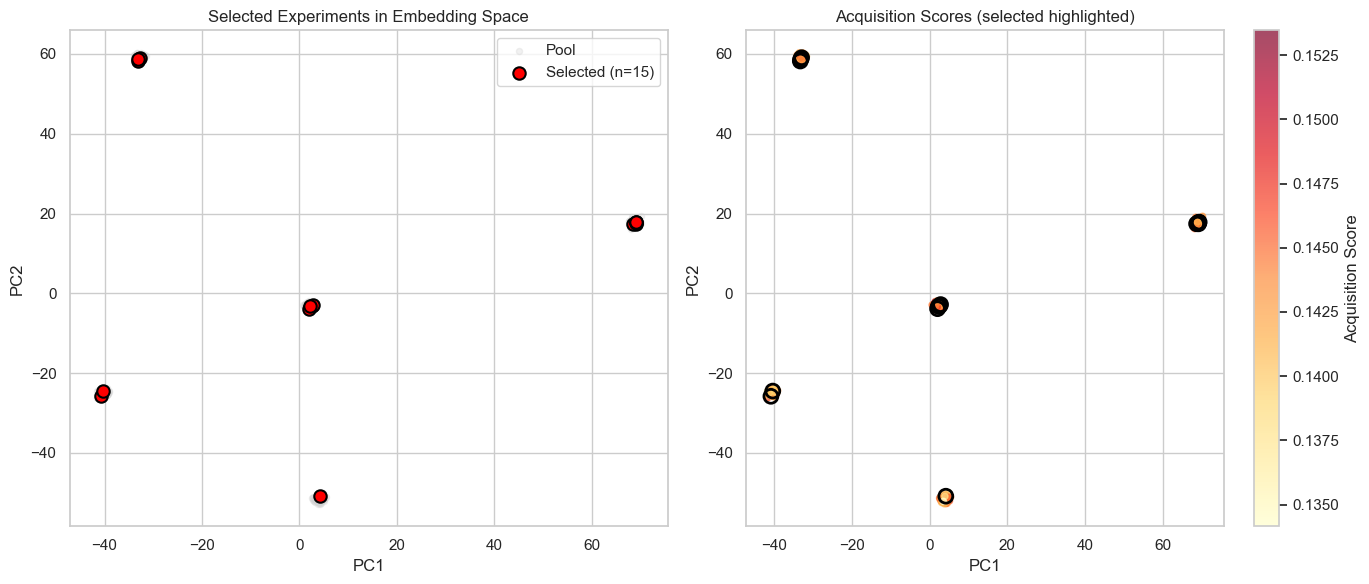

In [43]:
# Visualise selected samples in embedding space
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Selected samples
ax = axes[0]
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
           c='lightgray', alpha=0.3, s=20, label='Pool')
ax.scatter(embeddings_2d[selection_result.selected_indices, 0],
           embeddings_2d[selection_result.selected_indices, 1],
           c='red', s=80, edgecolors='black', linewidths=1.5,
           label=f'Selected (n={len(selection_result.selected_indices)})')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Selected Experiments in Embedding Space")
ax.legend()

# Plot 2: Acquisition scores
ax = axes[1]
scatter = ax.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=selection_result.all_scores,
    cmap='YlOrRd', alpha=0.7, s=20,
)
ax.scatter(embeddings_2d[selection_result.selected_indices, 0],
           embeddings_2d[selection_result.selected_indices, 1],
           facecolors='none', edgecolors='black', s=100, linewidths=2)
plt.colorbar(scatter, ax=ax, label='Acquisition Score')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Acquisition Scores (selected highlighted)")

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "embedding_space_selected_samples_pca.png")
plt.show()

### 6.4 Iterative Selection with Exclusion

When running multiple selection rounds, we need to exclude previously selected
samples. The `ExperimentSelector` handles this automatically.

In [44]:
# Reset selector for demonstration
selector.reset_exclusions()

# Perform multiple selection rounds
n_rounds = 3
n_per_round = 10

print(f"Performing {n_rounds} rounds of selection ({n_per_round} samples each)...")
print("=" * 60)

round_results = []
for round_num in range(n_rounds):
    result = selector.select(
        dataloader=pool_loader,
        embeddings=pool_data["embeddings"],
        n_select=n_per_round,
        show_progress=False,
    )
    round_results.append(result)
    
    print(f"\nRound {round_num + 1}:")
    print(f"  Selected IDs: {result.selected_ids[:5]}...")
    print(f"  Excluded so far: {len(selector.config.exclude_ids)}")

2026-02-15 23:37:00 | INFO     | protophen.active_learning.selection:reset_exclusions:366 | Reset exclusion list
2026-02-15 23:37:00 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=10)
2026-02-15 23:37:00 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...


Performing 3 rounds of selection (10 samples each)...


2026-02-15 23:37:00 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 500 samples. Mean uncertainty: 0.1427
2026-02-15 23:37:00 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:37:00 | INFO     | protophen.active_learning.selection:select:310 | Selected 10 experiments
2026-02-15 23:37:00 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 10 samples selected
  Method: hybrid
  Top scores: [0.15122668 0.15096858 0.14941365 0.14868861 0.14734073]
  Top IDs: ['pool_0308', 'pool_0317', 'pool_0360', 'pool_0146', 'pool_0499']
2026-02-15 23:37:00 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=10)
2026-02-15 23:37:00 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...



Round 1:
  Selected IDs: ['pool_0308', 'pool_0317', 'pool_0360', 'pool_0146', 'pool_0499']...
  Excluded so far: 10


2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 500 samples. Mean uncertainty: 0.1427
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:264 | Excluding 10 previously selected samples
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:310 | Selected 10 experiments
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 10 samples selected
  Method: hybrid
  Top scores: [0.15063883 0.1505373  0.15031831 0.14885077 0.14853385]
  Top IDs: ['pool_0025', 'pool_0193', 'pool_0099', 'pool_0260', 'pool_0315']
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=10)
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:249 | Estim


Round 2:
  Selected IDs: ['pool_0025', 'pool_0193', 'pool_0099', 'pool_0260', 'pool_0315']...
  Excluded so far: 20


2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 500 samples. Mean uncertainty: 0.1425
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:264 | Excluding 20 previously selected samples
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:310 | Selected 10 experiments
2026-02-15 23:37:01 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 10 samples selected
  Method: hybrid
  Top scores: [0.15088058 0.15070084 0.14932157 0.14839546 0.14579107]
  Top IDs: ['pool_0314', 'pool_0369', 'pool_0093', 'pool_0285', 'pool_0045']



Round 3:
  Selected IDs: ['pool_0314', 'pool_0369', 'pool_0093', 'pool_0285', 'pool_0045']...
  Excluded so far: 30


In [45]:
# Get selection summary
summary = selector.get_selection_summary()
print("\nSelection Summary:")
print(f"  Total selections: {summary['n_selections']}")
print(f"  Total samples selected: {summary['total_selected']}")
print(f"  Mean acquisition score: {summary['mean_acquisition_score']:.4f}")


Selection Summary:
  Total selections: 4
  Total samples selected: 45
  Mean acquisition score: 0.1488


2026-02-15 23:37:02 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\iterative_selection_pca.png


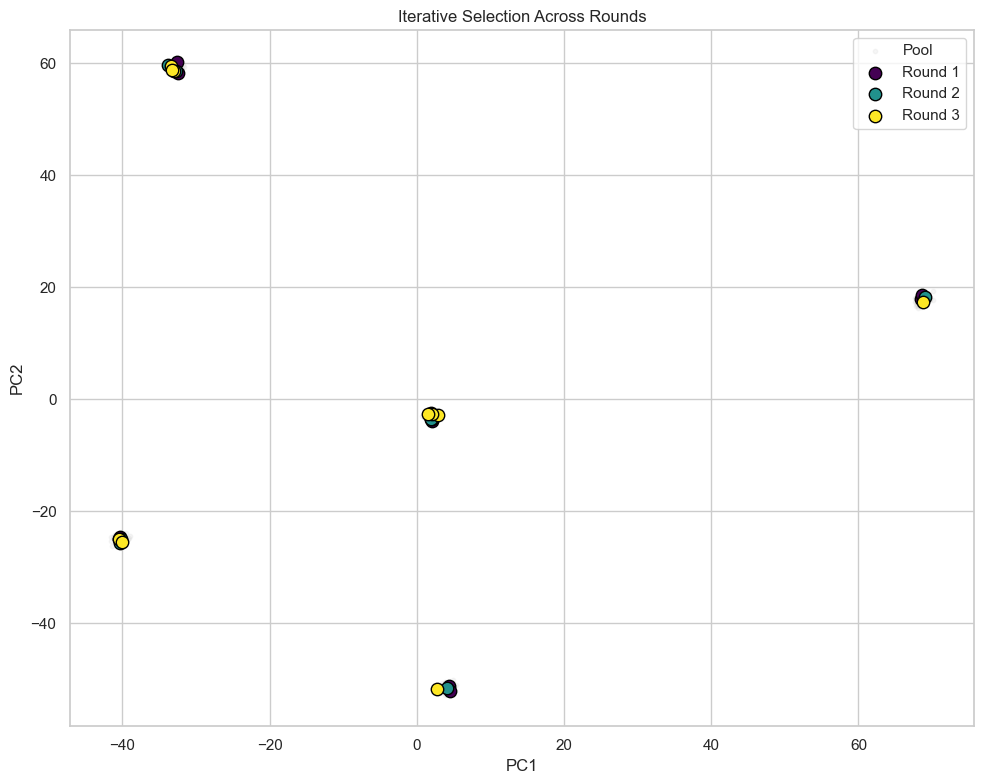

In [46]:
# Visualise iterative selection
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.viridis(np.linspace(0, 1, n_rounds))

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
           c='lightgray', alpha=0.2, s=10, label='Pool')

for i, result in enumerate(round_results):
    ax.scatter(
        embeddings_2d[result.selected_indices, 0],
        embeddings_2d[result.selected_indices, 1],
        c=[colors[i]], s=80, edgecolors='black', linewidths=1,
        label=f'Round {i+1}',
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Iterative Selection Across Rounds")
ax.legend()
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "iterative_selection_pca.png")
plt.show()

### 6.5 Selection Results Interpretation

In [47]:
# Convert result to dictionary for storage
result_dict = selection_result.to_dict()
print("Selection result as dictionary:")
for key, value in result_dict.items():
    if isinstance(value, list) and len(value) > 5:
        print(f"  {key}: {value[:5]}... (length {len(value)})")
    else:
        print(f"  {key}: {value}")

Selection result as dictionary:
  selected_indices: [382, 160, 229, 97, 23]... (length 15)
  selected_ids: ['pool_0382', 'pool_0160', 'pool_0229', 'pool_0097', 'pool_0023']... (length 15)
  acquisition_scores: [0.15346311032772064, 0.14991877973079681, 0.14966125786304474, 0.14869485795497894, 0.14748618006706238]... (length 15)
  all_scores: [0.1432398110628128, 0.14136436581611633, 0.13945512473583221, 0.14023691415786743, 0.14212505519390106]... (length 500)
  config: {'n_select': 15, 'uncertainty_method': 'mc_dropout', 'acquisition_method': 'hybrid'}


In [48]:
# Analyse what makes selected samples special
selected_idx = selection_result.selected_indices
unselected_idx = np.array([i for i in range(len(pool_data["ids"])) 
                           if i not in selected_idx])

print("Comparison: Selected vs Unselected")
print("-" * 50)

# Uncertainty comparison
selected_unc = epistemic_per_sample[selected_idx]
unselected_unc = epistemic_per_sample[unselected_idx]
print(f"Mean uncertainty - Selected: {selected_unc.mean():.4f}, "
      f"Unselected: {unselected_unc.mean():.4f}")

# Embedding statistics
selected_emb = pool_data["embeddings"][selected_idx]
unselected_emb = pool_data["embeddings"][unselected_idx]
print(f"Mean embedding norm - Selected: {np.linalg.norm(selected_emb, axis=1).mean():.2f}, "
      f"Unselected: {np.linalg.norm(unselected_emb, axis=1).mean():.2f}")

# Cluster distribution
selected_clusters = pool_data["clusters"][selected_idx]
print(f"Cluster distribution - Selected: {np.bincount(selected_clusters, minlength=5)}")

Comparison: Selected vs Unselected
--------------------------------------------------
Mean uncertainty - Selected: 0.1439, Unselected: 0.1425
Mean embedding norm - Selected: 86.62, Unselected: 86.26
Cluster distribution - Selected: [2 4 3 1 5]


## 7. Simulating Active Learning Loop

Let's simulate a complete active learning loop to see how model performance
improves with intelligently selected data.

### 7.1 Setup: Initial Training Set and Pool

In [49]:
# Create a larger pool for simulation
sim_train_data, sim_pool_data, sim_ground_truth = generate_synthetic_data(
    n_train=50,     # Small initial training set
    n_pool=500,     # Larger pool
    seed=123,
)

print("Simulation data:")
print(f"  Initial training: {len(sim_train_data['ids'])} samples")
print(f"  Pool: {len(sim_pool_data['ids'])} samples")

Simulation data:
  Initial training: 50 samples
  Pool: 500 samples


### 7.2 Oracle Function (Simulated Wet-Lab)

In real active learning, selected samples would be tested in the wet-lab.
Here, we simulate this with a "ground truth" function.

In [50]:
def oracle_label_fn(
    sample_ids: List[str],
    pool_data: Dict,
    ground_truth: np.ndarray,
    noise_std: float = 0.05,
) -> Dict[str, np.ndarray]:
    """
    Simulate wet-lab experiments by generating labels for selected proteins.
    
    In reality, this would be months of actual experiments!
    """
    # Find indices of selected samples
    id_to_idx = {pid: i for i, pid in enumerate(pool_data["ids"])}
    indices = [id_to_idx[sid] for sid in sample_ids if sid in id_to_idx]
    
    # Generate "experimental results" (phenotypes)
    embeddings = pool_data["embeddings"][indices]
    
    # Simple linear transformation plus noise
    phenotypes = embeddings @ ground_truth + np.random.randn(
        len(indices), ground_truth.shape[1]
    ) * noise_std
    
    return {
        "cell_painting": phenotypes.astype(np.float32),
        "indices": indices,
    }


# Test oracle
test_ids = sim_pool_data["ids"][:3]
test_labels = oracle_label_fn(test_ids, sim_pool_data, sim_ground_truth)
print(f"Oracle test - Generated labels for {len(test_ids)} samples")
print(f"  Phenotype shape: {test_labels['cell_painting'].shape}")

Oracle test - Generated labels for 3 samples
  Phenotype shape: (3, 1500)


### 7.3 Active Learning Loop Implementation

In [51]:
def run_al_simulation(
    initial_train_embeddings: np.ndarray,
    initial_train_phenotypes: np.ndarray,
    pool_embeddings: np.ndarray,
    pool_ids: List[str],
    pool_data: Dict,
    ground_truth: np.ndarray,
    n_iterations: int = 10,
    n_per_iteration: int = 10,
    acquisition_method: str = "hybrid",
    val_embeddings: Optional[np.ndarray] = None,
    val_phenotypes: Optional[np.ndarray] = None,
) -> Dict[str, List]:
    """
    Run active learning simulation.
    
    Returns history of metrics and selections.
    """
    history = {
        "iteration": [],
        "train_size": [],
        "train_mse": [],
        "val_mse": [],
        "val_r2": [],
        "selected_ids": [],
        "mean_uncertainty": [],
    }
    
    # Copy data to avoid modifying originals
    current_train_emb = initial_train_embeddings.copy()
    current_train_phen = initial_train_phenotypes.copy()
    remaining_pool_mask = np.ones(len(pool_ids), dtype=bool)
    
    for iteration in range(n_iterations):
        print(f"\n{'='*60}")
        print(f"Active Learning Iteration {iteration + 1}/{n_iterations}")
        print(f"{'='*60}")
        
        # Create training dataset
        train_samples = [
            ProtoPhenSample(
                protein_id=f"train_{i}",
                protein_embedding=current_train_emb[i],
                phenotypes={"cell_painting": current_train_phen[i]},
            )
            for i in range(len(current_train_emb))
        ]
        train_dataset = ProtoPhenDataset(samples=train_samples)
        train_loader = create_dataloader(train_dataset, batch_size=32, shuffle=True)
        
        # Create new model and train
        iter_model = ProToPhenModel(model_config).to(device)
        optimiser = torch.optim.Adam(iter_model.parameters(), lr=1e-3)
        criterion = nn.MSELoss()
        
        # Simple training loop
        iter_model.train()
        for epoch in range(50):  # Quick training
            epoch_loss = 0
            for batch in train_loader:
                optimiser.zero_grad()
                emb = batch["protein_embedding"].to(device)
                target = batch["cell_painting"].to(device)
                
                output = iter_model(emb, tasks=["cell_painting"])
                loss = criterion(output["cell_painting"], target)
                
                loss.backward()
                optimiser.step()
                epoch_loss += loss.item()
        
        train_mse = epoch_loss / len(train_loader)
        print(f"Training MSE: {train_mse:.4f}")
        
        # Evaluate on validation set if provided
        val_mse = None
        val_r2 = None
        if val_embeddings is not None:
            iter_model.eval()
            with torch.no_grad():
                val_emb = torch.from_numpy(val_embeddings).float().to(device)
                val_pred = iter_model(val_emb, tasks=["cell_painting"])["cell_painting"]
                val_pred = val_pred.cpu().numpy()
                
                val_mse = ((val_pred - val_phenotypes) ** 2).mean()
                
                # Compute R² per feature and average
                r2_scores = []
                for j in range(val_phenotypes.shape[1]):
                    ss_res = ((val_phenotypes[:, j] - val_pred[:, j]) ** 2).sum()
                    ss_tot = ((val_phenotypes[:, j] - val_phenotypes[:, j].mean()) ** 2).sum()
                    r2 = 1 - ss_res / (ss_tot + 1e-8)
                    r2_scores.append(r2)
                val_r2 = np.mean(r2_scores)
                
            print(f"Validation MSE: {val_mse:.4f}, R²: {val_r2:.4f}")
        
        # Create pool loader for remaining samples
        remaining_indices = np.where(remaining_pool_mask)[0]
        remaining_emb = pool_embeddings[remaining_indices]
        remaining_ids = [pool_ids[i] for i in remaining_indices]
        
        pool_inference = ProteinInferenceDataset(
            protein_embeddings=remaining_emb,
            protein_ids=remaining_ids,
        )
        pool_loader = create_dataloader(pool_inference, batch_size=32, shuffle=False)
        
        # Select samples
        selector_config = SelectionConfig(
            n_select=n_per_iteration,
            uncertainty_method="mc_dropout",
            n_mc_samples=15,
            acquisition_method=acquisition_method,
        )
        selector = ExperimentSelector(iter_model, selector_config, device=str(device))
        
        selection = selector.select(pool_loader, embeddings=remaining_emb, show_progress=False)
        
        # Get mean uncertainty of selected samples
        mean_unc = selection.uncertainty_estimates.get_uncertainty(reduction="mean").mean()
        
        # "Label" selected samples (simulate wet-lab)
        new_labels = oracle_label_fn(selection.selected_ids, pool_data, ground_truth)
        
        # Find original pool indices of selected samples
        id_to_orig_idx = {pid: i for i, pid in enumerate(pool_ids)}
        selected_orig_indices = [id_to_orig_idx[sid] for sid in selection.selected_ids]
        
        # Add to training set
        new_embeddings = pool_embeddings[selected_orig_indices]
        current_train_emb = np.vstack([current_train_emb, new_embeddings])
        current_train_phen = np.vstack([current_train_phen, new_labels["cell_painting"]])
        
        # Remove from pool
        remaining_pool_mask[selected_orig_indices] = False
        
        # Record history
        history["iteration"].append(iteration + 1)
        history["train_size"].append(len(current_train_emb))
        history["train_mse"].append(train_mse)
        history["val_mse"].append(val_mse)
        history["val_r2"].append(val_r2)
        history["selected_ids"].append(selection.selected_ids)
        history["mean_uncertainty"].append(mean_unc)
        
        print(f"Selected {len(selection.selected_ids)} samples, "
              f"new training size: {len(current_train_emb)}")
    
    return history

### 7.4 Run the Simulation

In [52]:
# Create validation set (subset of pool with known labels)
val_indices = np.random.choice(len(sim_pool_data["ids"]), size=100, replace=False)
val_embeddings = sim_pool_data["embeddings"][val_indices]
val_phenotypes = (val_embeddings @ sim_ground_truth + 
                  np.random.randn(100, sim_ground_truth.shape[1]) * 0.05).astype(np.float32)

print(f"Validation set: {len(val_embeddings)} samples")

Validation set: 100 samples


In [53]:
# Run active learning simulation with hybrid acquisition
print("Running Active Learning Simulation (Hybrid Strategy)")
print("=" * 60)

al_history_hybrid = run_al_simulation(
    initial_train_embeddings=sim_train_data["embeddings"],
    initial_train_phenotypes=sim_train_data["phenotypes"],
    pool_embeddings=sim_pool_data["embeddings"],
    pool_ids=sim_pool_data["ids"],
    pool_data=sim_pool_data,
    ground_truth=sim_ground_truth,
    n_iterations=8,
    n_per_iteration=15,
    acquisition_method="hybrid",
    val_embeddings=val_embeddings,
    val_phenotypes=val_phenotypes,
)

2026-02-15 23:37:02 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Running Active Learning Simulation (Hybrid Strategy)

Active Learning Iteration 1/8


2026-02-15 23:37:20 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:37:20 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...


Training MSE: 0.0207
Validation MSE: 74.7525, R²: -0.4023


2026-02-15 23:37:36 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 500 samples. Mean uncertainty: 0.0890
2026-02-15 23:37:36 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:37:36 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:37:36 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [0.1005683  0.09823349 0.09298383 0.09060401 0.0990434 ]
  Top IDs: ['pool_0233', 'pool_0376', 'pool_0277', 'pool_0339', 'pool_0097']


Selected 15 samples, new training size: 65

Active Learning Iteration 2/8


2026-02-15 23:37:37 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 8.1299
Validation MSE: 52.5158, R²: -0.0127


2026-02-15 23:37:54 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:37:54 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:38:09 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 485 samples. Mean uncertainty: 0.1558
2026-02-15 23:38:09 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:38:09 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:38:09 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [0.19275695 0.19200546 0.179754   0.19086137 0.18872909]
  Top IDs: ['pool_0168', 'pool_0459', 'pool_0458', 'pool_0017', 'pool_0078']


Selected 15 samples, new training size: 80

Active Learning Iteration 3/8


2026-02-15 23:38:10 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 12.4736
Validation MSE: 47.5179, R²: 0.0901


2026-02-15 23:38:26 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:38:26 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:38:42 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 470 samples. Mean uncertainty: 0.1893
2026-02-15 23:38:42 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:38:42 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:38:42 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [0.24661565 0.23452117 0.22670206 0.21725546 0.23332492]
  Top IDs: ['pool_0465', 'pool_0264', 'pool_0267', 'pool_0170', 'pool_0360']


Selected 15 samples, new training size: 95

Active Learning Iteration 4/8


2026-02-15 23:38:42 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 12.5445
Validation MSE: 27.5102, R²: 0.4505


2026-02-15 23:38:59 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:38:59 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:39:14 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 455 samples. Mean uncertainty: 0.5125
2026-02-15 23:39:14 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:39:14 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:39:14 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [1.7038279 0.9122552 1.5053856 1.480168  1.4710363]
  Top IDs: ['pool_0208', 'pool_0341', 'pool_0147', 'pool_0185', 'pool_0487']


Selected 15 samples, new training size: 110

Active Learning Iteration 5/8


2026-02-15 23:39:15 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 12.3141
Validation MSE: 29.6394, R²: 0.4014


2026-02-15 23:39:32 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:39:32 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:39:47 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 440 samples. Mean uncertainty: 0.3310
2026-02-15 23:39:47 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:39:47 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:39:47 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [1.3787596 1.1881077 1.1628708 1.128625  1.1279243]
  Top IDs: ['pool_0473', 'pool_0187', 'pool_0167', 'pool_0113', 'pool_0366']


Selected 15 samples, new training size: 125

Active Learning Iteration 6/8


2026-02-15 23:39:48 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 10.5562
Validation MSE: 28.3539, R²: 0.4384


2026-02-15 23:40:05 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:40:05 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:40:21 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 425 samples. Mean uncertainty: 0.6321
2026-02-15 23:40:21 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:40:21 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:40:21 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [1.4713818 1.2265698 1.0373355 1.448927  1.4085181]
  Top IDs: ['pool_0492', 'pool_0363', 'pool_0302', 'pool_0042', 'pool_0449']


Selected 15 samples, new training size: 140

Active Learning Iteration 7/8


2026-02-15 23:40:21 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 17.8343
Validation MSE: 17.6457, R²: 0.6351


2026-02-15 23:40:38 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:40:38 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:40:54 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 410 samples. Mean uncertainty: 0.2245
2026-02-15 23:40:54 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:40:54 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:40:54 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [0.32377902 0.3040197  0.29028323 0.28700167 0.28283122]
  Top IDs: ['pool_0141', 'pool_0215', 'pool_0299', 'pool_0407', 'pool_0008']


Selected 15 samples, new training size: 155

Active Learning Iteration 8/8


2026-02-15 23:40:54 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 15.1923
Validation MSE: 16.1627, R²: 0.6620


2026-02-15 23:41:11 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:41:11 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:41:26 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 395 samples. Mean uncertainty: 0.4145
2026-02-15 23:41:26 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using hybrid...
2026-02-15 23:41:26 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:41:26 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: hybrid
  Top scores: [1.6892985 1.426151  1.4271306 1.3185419 1.2915297]
  Top IDs: ['pool_0312', 'pool_0387', 'pool_0364', 'pool_0495', 'pool_0110']


Selected 15 samples, new training size: 170


In [54]:
# Run comparison with uncertainty-only acquisition
print("\n" + "=" * 60)
print("Running Active Learning Simulation (Uncertainty-Only Strategy)")
print("=" * 60)

al_history_uncertainty = run_al_simulation(
    initial_train_embeddings=sim_train_data["embeddings"],
    initial_train_phenotypes=sim_train_data["phenotypes"],
    pool_embeddings=sim_pool_data["embeddings"],
    pool_ids=sim_pool_data["ids"],
    pool_data=sim_pool_data,
    ground_truth=sim_ground_truth,
    n_iterations=8,
    n_per_iteration=15,
    acquisition_method="uncertainty",
    val_embeddings=val_embeddings,
    val_phenotypes=val_phenotypes,
)

2026-02-15 23:41:28 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']



Running Active Learning Simulation (Uncertainty-Only Strategy)

Active Learning Iteration 1/8


2026-02-15 23:41:43 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:41:43 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...


Training MSE: 0.0191
Validation MSE: 74.7551, R²: -0.4023


2026-02-15 23:41:59 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 500 samples. Mean uncertainty: 0.0889
2026-02-15 23:41:59 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using uncertainty...
2026-02-15 23:41:59 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:41:59 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: uncertainty
  Top scores: [0.10142981 0.10108212 0.10073625 0.10040501 0.09989239]
  Top IDs: ['pool_0104', 'pool_0403', 'pool_0308', 'pool_0222', 'pool_0319']


Selected 15 samples, new training size: 65

Active Learning Iteration 2/8


2026-02-15 23:42:00 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 10.8679
Validation MSE: 54.6902, R²: -0.0503


2026-02-15 23:42:16 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:42:16 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:42:32 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 485 samples. Mean uncertainty: 0.1500
2026-02-15 23:42:32 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using uncertainty...
2026-02-15 23:42:32 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:42:32 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: uncertainty
  Top scores: [0.2058582  0.20271565 0.20035608 0.20019642 0.19861881]
  Top IDs: ['pool_0328', 'pool_0101', 'pool_0405', 'pool_0159', 'pool_0206']


Selected 15 samples, new training size: 80

Active Learning Iteration 3/8


2026-02-15 23:42:33 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 10.0838
Validation MSE: 49.4039, R²: 0.0510


2026-02-15 23:42:50 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:42:50 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:43:06 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 470 samples. Mean uncertainty: 0.1869
2026-02-15 23:43:06 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using uncertainty...
2026-02-15 23:43:06 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:43:06 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: uncertainty
  Top scores: [0.38139084 0.3754716  0.37092033 0.3695297  0.36584464]
  Top IDs: ['pool_0285', 'pool_0310', 'pool_0013', 'pool_0317', 'pool_0490']


Selected 15 samples, new training size: 95

Active Learning Iteration 4/8


2026-02-15 23:43:06 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 6.9048
Validation MSE: 46.0733, R²: 0.1070


2026-02-15 23:43:23 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:43:23 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:43:39 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 455 samples. Mean uncertainty: 0.2948
2026-02-15 23:43:39 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using uncertainty...
2026-02-15 23:43:39 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:43:39 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: uncertainty
  Top scores: [1.391106  1.2604939 1.192749  1.1812599 1.1795182]
  Top IDs: ['pool_0111', 'pool_0214', 'pool_0037', 'pool_0130', 'pool_0397']


Selected 15 samples, new training size: 110

Active Learning Iteration 5/8


2026-02-15 23:43:40 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 9.8095
Validation MSE: 45.5166, R²: 0.1228


2026-02-15 23:43:57 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:43:57 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:44:12 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 440 samples. Mean uncertainty: 0.1724
2026-02-15 23:44:12 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using uncertainty...
2026-02-15 23:44:12 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:44:12 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: uncertainty
  Top scores: [0.27480018 0.26308206 0.25879204 0.2576234  0.2531791 ]
  Top IDs: ['pool_0070', 'pool_0154', 'pool_0309', 'pool_0127', 'pool_0080']


Selected 15 samples, new training size: 125

Active Learning Iteration 6/8


2026-02-15 23:44:13 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 10.0574
Validation MSE: 44.8015, R²: 0.1341


2026-02-15 23:44:29 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:44:29 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:44:44 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 425 samples. Mean uncertainty: 0.1774
2026-02-15 23:44:44 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using uncertainty...
2026-02-15 23:44:44 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:44:44 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: uncertainty
  Top scores: [0.27223098 0.2660144  0.2615919  0.2576138  0.25547972]
  Top IDs: ['pool_0477', 'pool_0202', 'pool_0006', 'pool_0400', 'pool_0414']


Selected 15 samples, new training size: 140

Active Learning Iteration 7/8


2026-02-15 23:44:45 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 8.8769
Validation MSE: 44.4865, R²: 0.1396


2026-02-15 23:45:02 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:45:02 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:45:17 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 410 samples. Mean uncertainty: 0.1712
2026-02-15 23:45:17 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using uncertainty...
2026-02-15 23:45:17 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:45:17 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: uncertainty
  Top scores: [0.29805148 0.28853282 0.26484594 0.26210588 0.26168495]
  Top IDs: ['pool_0009', 'pool_0239', 'pool_0052', 'pool_0171', 'pool_0007']


Selected 15 samples, new training size: 155

Active Learning Iteration 8/8


2026-02-15 23:45:18 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Training MSE: 9.4822
Validation MSE: 44.2827, R²: 0.1435


2026-02-15 23:45:36 | INFO     | protophen.active_learning.selection:select:246 | Starting experiment selection (n_select=15)
2026-02-15 23:45:36 | INFO     | protophen.active_learning.selection:select:249 | Estimating uncertainty...
2026-02-15 23:45:51 | INFO     | protophen.active_learning.selection:select:256 | Uncertainty estimated for 395 samples. Mean uncertainty: 0.1803
2026-02-15 23:45:51 | INFO     | protophen.active_learning.selection:select:269 | Computing acquisition scores using uncertainty...
2026-02-15 23:45:51 | INFO     | protophen.active_learning.selection:select:310 | Selected 15 experiments
2026-02-15 23:45:51 | INFO     | protophen.active_learning.selection:select:311 | Selection Result: 15 samples selected
  Method: uncertainty
  Top scores: [0.27434486 0.2585199  0.2539579  0.2537228  0.25291455]
  Top IDs: ['pool_0172', 'pool_0361', 'pool_0478', 'pool_0235', 'pool_0452']


Selected 15 samples, new training size: 170


In [55]:
# Run comparison with random acquisition (baseline)
print("\n" + "=" * 60)
print("Running Active Learning Simulation (Random Baseline)")
print("=" * 60)

# For random, we'll manually implement since it's not in acquisition functions
def run_random_baseline(
    initial_train_embeddings: np.ndarray,
    initial_train_phenotypes: np.ndarray,
    pool_embeddings: np.ndarray,
    pool_ids: List[str],
    pool_data: Dict,
    ground_truth: np.ndarray,
    n_iterations: int = 8,
    n_per_iteration: int = 15,
    val_embeddings: Optional[np.ndarray] = None,
    val_phenotypes: Optional[np.ndarray] = None,
) -> Dict[str, List]:
    """Run random selection baseline."""
    history = {
        "iteration": [],
        "train_size": [],
        "train_mse": [],
        "val_mse": [],
        "val_r2": [],
        "selected_ids": [],
        "mean_uncertainty": [],
    }
    
    current_train_emb = initial_train_embeddings.copy()
    current_train_phen = initial_train_phenotypes.copy()
    remaining_indices = list(range(len(pool_ids)))
    
    for iteration in range(n_iterations):
        print(f"\nRandom Baseline - Iteration {iteration + 1}/{n_iterations}")
        
        # Create and train model (same as before)
        train_samples = [
            ProtoPhenSample(
                protein_id=f"train_{i}",
                protein_embedding=current_train_emb[i],
                phenotypes={"cell_painting": current_train_phen[i]},
            )
            for i in range(len(current_train_emb))
        ]
        train_dataset = ProtoPhenDataset(samples=train_samples)
        train_loader = create_dataloader(train_dataset, batch_size=32, shuffle=True)
        
        iter_model = ProToPhenModel(model_config).to(device)
        optimiser = torch.optim.Adam(iter_model.parameters(), lr=1e-3)
        criterion = nn.MSELoss()
        
        iter_model.train()
        for epoch in range(50):
            epoch_loss = 0
            for batch in train_loader:
                optimiser.zero_grad()
                emb = batch["protein_embedding"].to(device)
                target = batch["cell_painting"].to(device)
                output = iter_model(emb, tasks=["cell_painting"])
                loss = criterion(output["cell_painting"], target)
                loss.backward()
                optimiser.step()
                epoch_loss += loss.item()
        
        train_mse = epoch_loss / len(train_loader)
        
        # Evaluate
        val_mse = None
        val_r2 = None
        if val_embeddings is not None:
            iter_model.eval()
            with torch.no_grad():
                val_emb = torch.from_numpy(val_embeddings).float().to(device)
                val_pred = iter_model(val_emb, tasks=["cell_painting"])["cell_painting"]
                val_pred = val_pred.cpu().numpy()
                
                val_mse = ((val_pred - val_phenotypes) ** 2).mean()
                r2_scores = []
                for j in range(val_phenotypes.shape[1]):
                    ss_res = ((val_phenotypes[:, j] - val_pred[:, j]) ** 2).sum()
                    ss_tot = ((val_phenotypes[:, j] - val_phenotypes[:, j].mean()) ** 2).sum()
                    r2 = 1 - ss_res / (ss_tot + 1e-8)
                    r2_scores.append(r2)
                val_r2 = np.mean(r2_scores)
        
        # Random selection
        n_select = min(n_per_iteration, len(remaining_indices))
        selected_local_indices = np.random.choice(len(remaining_indices), size=n_select, replace=False)
        selected_pool_indices = [remaining_indices[i] for i in selected_local_indices]
        selected_ids = [pool_ids[i] for i in selected_pool_indices]
        
        # Get labels
        new_labels = oracle_label_fn(selected_ids, pool_data, ground_truth)
        
        # Update training set
        new_embeddings = pool_embeddings[selected_pool_indices]
        current_train_emb = np.vstack([current_train_emb, new_embeddings])
        current_train_phen = np.vstack([current_train_phen, new_labels["cell_painting"]])
        
        # Remove from pool
        for idx in sorted(selected_local_indices, reverse=True):
            remaining_indices.pop(idx)
        
        # Record
        history["iteration"].append(iteration + 1)
        history["train_size"].append(len(current_train_emb))
        history["train_mse"].append(train_mse)
        history["val_mse"].append(val_mse)
        history["val_r2"].append(val_r2)
        history["selected_ids"].append(selected_ids)
        history["mean_uncertainty"].append(0)  # Not computed for random
        
        print(f"Val R²: {val_r2:.4f}, Training size: {len(current_train_emb)}")
    
    return history


al_history_random = run_random_baseline(
    initial_train_embeddings=sim_train_data["embeddings"],
    initial_train_phenotypes=sim_train_data["phenotypes"],
    pool_embeddings=sim_pool_data["embeddings"],
    pool_ids=sim_pool_data["ids"],
    pool_data=sim_pool_data,
    ground_truth=sim_ground_truth,
    n_iterations=8,
    n_per_iteration=15,
    val_embeddings=val_embeddings,
    val_phenotypes=val_phenotypes,
)

2026-02-15 23:45:53 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']



Running Active Learning Simulation (Random Baseline)

Random Baseline - Iteration 1/8
Val R²: -0.4025, Training size: 65

Random Baseline - Iteration 2/8


2026-02-15 23:46:09 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Val R²: 0.0498, Training size: 80

Random Baseline - Iteration 3/8


2026-02-15 23:46:27 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Val R²: -0.0548, Training size: 95

Random Baseline - Iteration 4/8


2026-02-15 23:46:44 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Val R²: 0.4005, Training size: 110

Random Baseline - Iteration 5/8


2026-02-15 23:47:01 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Val R²: 0.5994, Training size: 125

Random Baseline - Iteration 6/8


2026-02-15 23:47:18 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Val R²: 0.6236, Training size: 140

Random Baseline - Iteration 7/8


2026-02-15 23:47:35 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Val R²: 0.7300, Training size: 155

Random Baseline - Iteration 8/8


2026-02-15 23:47:51 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Val R²: 0.7198, Training size: 170


### 7.5 Tracking Performance Improvement

2026-02-15 23:48:09 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\AL_performance_improvement_by_method.png


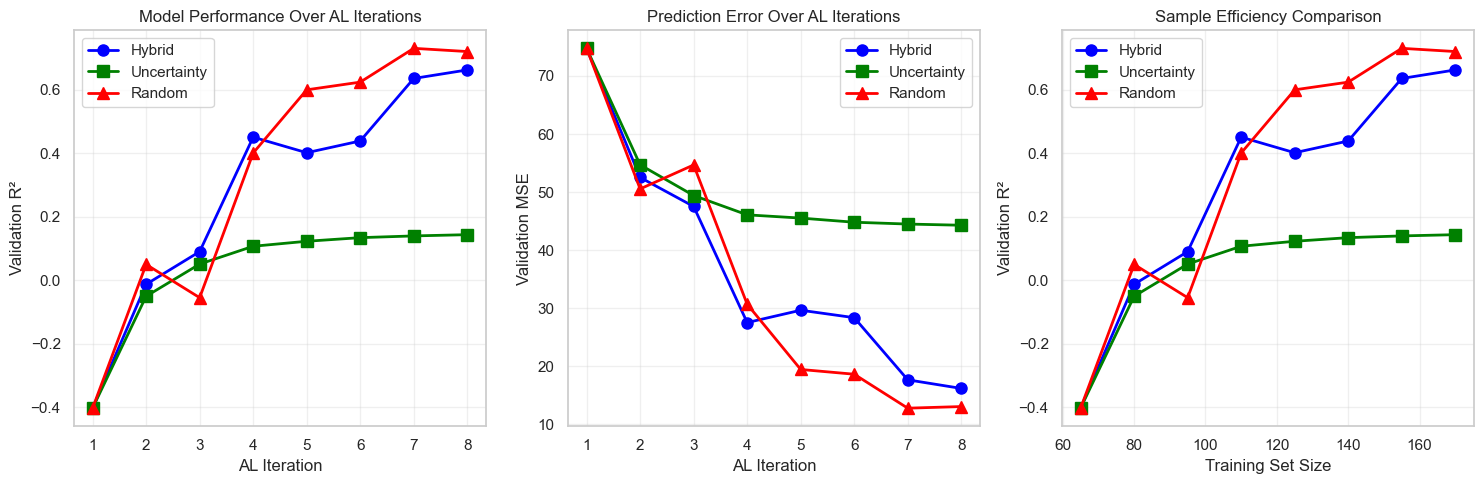

In [56]:
# Compare strategies
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Validation R² over iterations
ax = axes[0]
ax.plot(al_history_hybrid["iteration"], al_history_hybrid["val_r2"], 
        'o-', linewidth=2, markersize=8, label='Hybrid', color='blue')
ax.plot(al_history_uncertainty["iteration"], al_history_uncertainty["val_r2"], 
        's-', linewidth=2, markersize=8, label='Uncertainty', color='green')
ax.plot(al_history_random["iteration"], al_history_random["val_r2"], 
        '^-', linewidth=2, markersize=8, label='Random', color='red')
ax.set_xlabel("AL Iteration")
ax.set_ylabel("Validation R²")
ax.set_title("Model Performance Over AL Iterations")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Validation MSE over iterations
ax = axes[1]
ax.plot(al_history_hybrid["iteration"], al_history_hybrid["val_mse"], 
        'o-', linewidth=2, markersize=8, label='Hybrid', color='blue')
ax.plot(al_history_uncertainty["iteration"], al_history_uncertainty["val_mse"], 
        's-', linewidth=2, markersize=8, label='Uncertainty', color='green')
ax.plot(al_history_random["iteration"], al_history_random["val_mse"], 
        '^-', linewidth=2, markersize=8, label='Random', color='red')
ax.set_xlabel("AL Iteration")
ax.set_ylabel("Validation MSE")
ax.set_title("Prediction Error Over AL Iterations")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Performance vs training size
ax = axes[2]
ax.plot(al_history_hybrid["train_size"], al_history_hybrid["val_r2"], 
        'o-', linewidth=2, markersize=8, label='Hybrid', color='blue')
ax.plot(al_history_uncertainty["train_size"], al_history_uncertainty["val_r2"], 
        's-', linewidth=2, markersize=8, label='Uncertainty', color='green')
ax.plot(al_history_random["train_size"], al_history_random["val_r2"], 
        '^-', linewidth=2, markersize=8, label='Random', color='red')
ax.set_xlabel("Training Set Size")
ax.set_ylabel("Validation R²")
ax.set_title("Sample Efficiency Comparison")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "AL_performance_improvement_by_method.png")
plt.show()

In [57]:
# Summary statistics
print("\nActive Learning Simulation Summary")
print("=" * 60)

strategies = {
    "Hybrid": al_history_hybrid,
    "Uncertainty": al_history_uncertainty,
    "Random": al_history_random,
}

summary_data = []
for name, history in strategies.items():
    final_r2 = history["val_r2"][-1]
    initial_r2 = history["val_r2"][0]
    improvement = final_r2 - initial_r2
    
    summary_data.append({
        "Strategy": name,
        "Initial R²": initial_r2,
        "Final R²": final_r2,
        "Improvement": improvement,
        "Final MSE": history["val_mse"][-1],
        "Final Train Size": history["train_size"][-1],
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


Active Learning Simulation Summary
   Strategy  Initial R²  Final R²  Improvement  Final MSE  Final Train Size
     Hybrid   -0.402313  0.662005     1.064319  16.162722               170
Uncertainty   -0.402274  0.143527     0.545801  44.282654               170
     Random   -0.402547  0.719844     1.122391  13.036975               170


In [58]:
# Calculate area under the learning curve (AULC) - higher is better
print("\nArea Under Learning Curve (AULC):")
for name, history in strategies.items():
    aulc = np.trapz(history["val_r2"], history["train_size"])
    print(f"  {name}: {aulc:.2f}")


Area Under Learning Curve (AULC):
  Hybrid: 31.99
  Uncertainty: 5.62
  Random: 37.61


## 8. Model Interpretation

Understanding *why* certain proteins were selected helps validate the active
learning strategy and can provide biological insights.

### 8.1 Gradient-Based Interpretation

In [59]:
# Create interpreter for the trained model
interpreter = GradientInterpreter(model, config=None)

# Get embeddings of selected proteins from our earlier selection
selected_embeddings = torch.from_numpy(
    pool_data["embeddings"][selection_result.selected_indices]
).float()

print(f"Interpreting {len(selected_embeddings)} selected proteins...")

Interpreting 15 selected proteins...


In [60]:
# Compute gradient-based attributions
gradient_results = interpreter.explain(
    selected_embeddings,
    task="cell_painting",
    method="vanilla",
)

print("Gradient interpretation results:")
print(f"  Gradients shape: {gradient_results['gradients'].shape}")
print(f"  Importance shape: {gradient_results['importance'].shape}")
print(f"  Saliency shape: {gradient_results['saliency'].shape}")

Gradient interpretation results:
  Gradients shape: torch.Size([15, 1719])
  Importance shape: torch.Size([15, 1719])
  Saliency shape: torch.Size([15, 1719])


In [61]:
# Analyse feature importance
feature_importance = interpreter.feature_importance(
    selected_embeddings,
    task="cell_painting",
    aggregate="mean",
)

print(f"\nFeature importance shape: {feature_importance.shape}")
print(f"Top 10 most important features:")
top_features = np.argsort(feature_importance)[-10:][::-1]
for rank, feat_idx in enumerate(top_features):
    print(f"  {rank+1}. Feature {feat_idx}: importance = {feature_importance[feat_idx]:.4f}")


Feature importance shape: (1719,)
Top 10 most important features:
  1. Feature 1648: importance = 0.1962
  2. Feature 1537: importance = 0.1860
  3. Feature 1138: importance = 0.1836
  4. Feature 37: importance = 0.1747
  5. Feature 1368: importance = 0.1654
  6. Feature 456: importance = 0.1576
  7. Feature 1311: importance = 0.1568
  8. Feature 301: importance = 0.1558
  9. Feature 466: importance = 0.1519
  10. Feature 1364: importance = 0.1452


2026-02-15 23:48:10 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\feature_importance_distribution.png


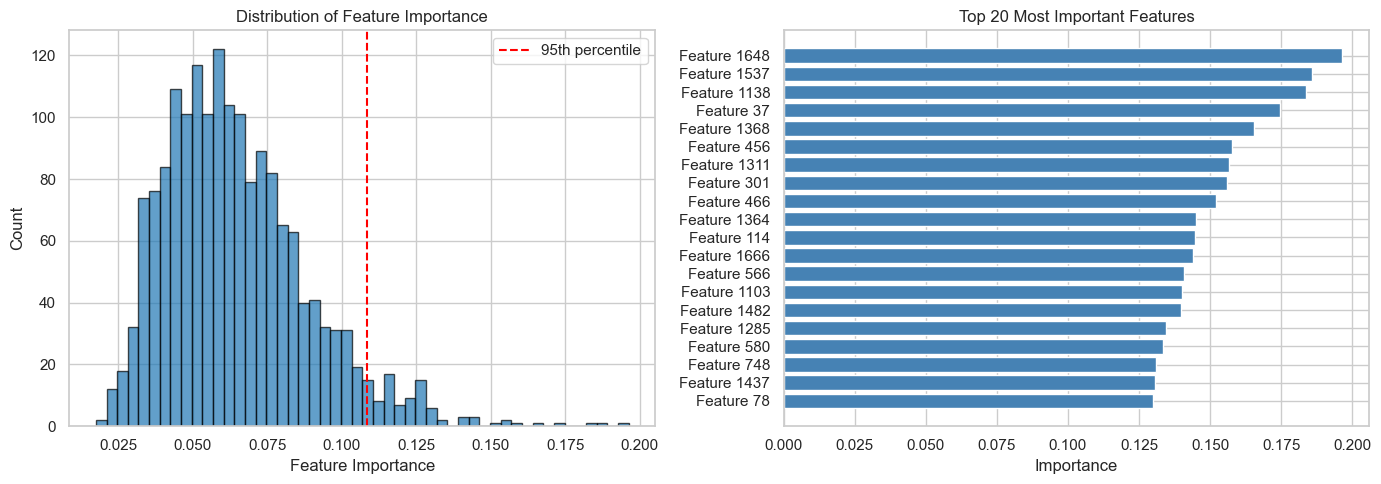

In [62]:
# Visualise feature importance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram of feature importance
ax = axes[0]
ax.hist(feature_importance, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(np.percentile(feature_importance, 95), color='red', 
           linestyle='--', label='95th percentile')
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Count")
ax.set_title("Distribution of Feature Importance")
ax.legend()

# Plot 2: Top features bar plot
ax = axes[1]
top_n = 20
top_idx = np.argsort(feature_importance)[-top_n:][::-1]
ax.barh(range(top_n), feature_importance[top_idx], color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels([f"Feature {i}" for i in top_idx])
ax.set_xlabel("Importance")
ax.set_title(f"Top {top_n} Most Important Features")
ax.invert_yaxis()

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "feature_importance_distribution.png")
plt.show()

### 8.2 Integrated Gradients

In [63]:
# Create Integrated Gradients interpreter
ig_interpreter = IntegratedGradientsInterpreter(model)

# Compute attributions for a subset (IG is computationally intensive)
subset_embeddings = selected_embeddings[:5]

print("Computing Integrated Gradients...")
ig_results = ig_interpreter.explain(
    subset_embeddings,
    task="cell_painting",
    target_idx=0,  # Explain first phenotype feature
    n_steps=50,
)

print(f"\nIntegrated Gradients results:")
print(f"  Attributions shape: {ig_results['attributions'].shape}")
print(f"  Convergence delta: {ig_results['convergence_delta'].mean():.6f}")

Computing Integrated Gradients...

Integrated Gradients results:
  Attributions shape: torch.Size([5, 1719])
  Convergence delta: 4.826071


2026-02-15 23:48:10 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\integrated_gradients_distribution.png


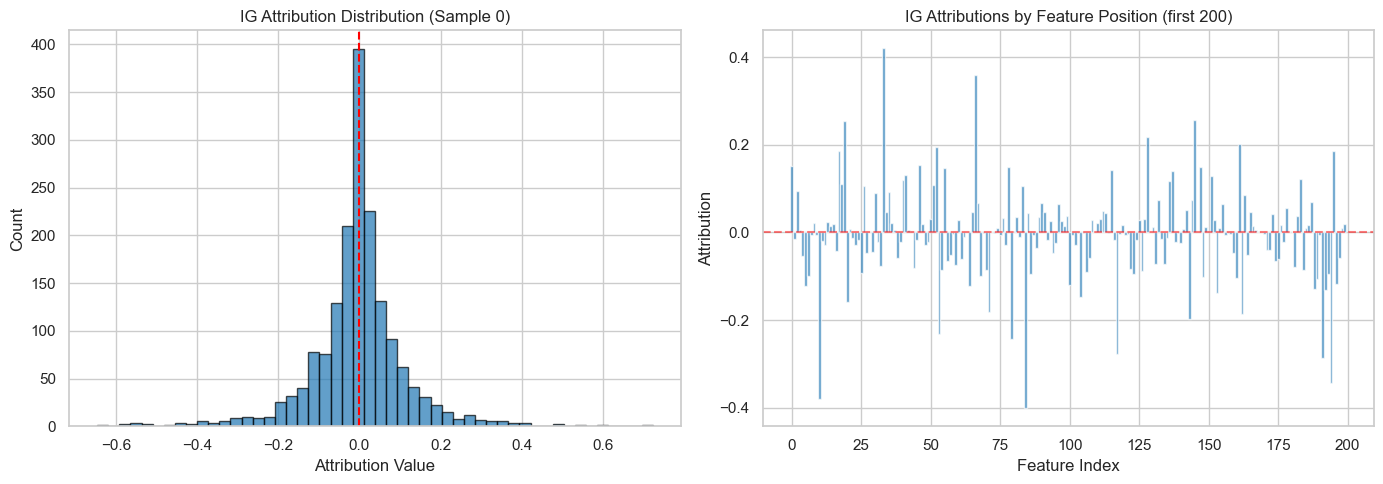

In [64]:
# Visualise IG attributions for a single sample
sample_idx = 0
attributions = ig_results['attributions'][sample_idx].numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Attribution distribution
ax = axes[0]
ax.hist(attributions, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--')
ax.set_xlabel("Attribution Value")
ax.set_ylabel("Count")
ax.set_title(f"IG Attribution Distribution (Sample {sample_idx})")

# Plot 2: Attribution by feature position
ax = axes[1]
# Show first 200 features for clarity
n_show = 200
ax.bar(range(n_show), attributions[:n_show], width=1.0, alpha=0.7)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel("Feature Index")
ax.set_ylabel("Attribution")
ax.set_title(f"IG Attributions by Feature Position (first {n_show})")

# Highlight ESM-2 vs physicochemical boundary
esm_dim = 1280
if n_show > esm_dim:
    ax.axvline(esm_dim, color='green', linestyle='--', 
               label=f'ESM-2|Physicochemical boundary')
    ax.legend()

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "integrated_gradients_distribution.png")
plt.show()

### 8.3 Embedding Type Contribution

Understand how much ESM-2 embeddings vs physicochemical features contribute
to predictions for selected proteins.

In [65]:
# Define embedding ranges
ESM2_DIM = 1280
PHYSICOCHEMICAL_DIM = 439

embedding_ranges = {
    "ESM-2": (0, ESM2_DIM),
    "Physicochemical": (ESM2_DIM, ESM2_DIM + PHYSICOCHEMICAL_DIM),
}

# Create feature ablation interpreter
ablation_interpreter = FeatureAblationInterpreter(model)

# Compute group importance
print("Computing embedding type contributions via ablation...")
group_importance = ablation_interpreter.compute_group_importance(
    selected_embeddings,
    feature_groups=embedding_ranges,
    task="cell_painting",
)

print("\nEmbedding Type Contributions:")
print("-" * 40)
total_importance = sum(group_importance.values())
for name, importance in group_importance.items():
    pct = (importance / total_importance) * 100 if total_importance > 0 else 0
    print(f"  {name}: {importance:.4f} ({pct:.1f}%)")

Computing embedding type contributions via ablation...

Embedding Type Contributions:
----------------------------------------
  ESM-2: 0.0003 (26.9%)
  Physicochemical: 0.0008 (73.1%)


2026-02-15 23:48:11 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\embedding_type_contribution.png


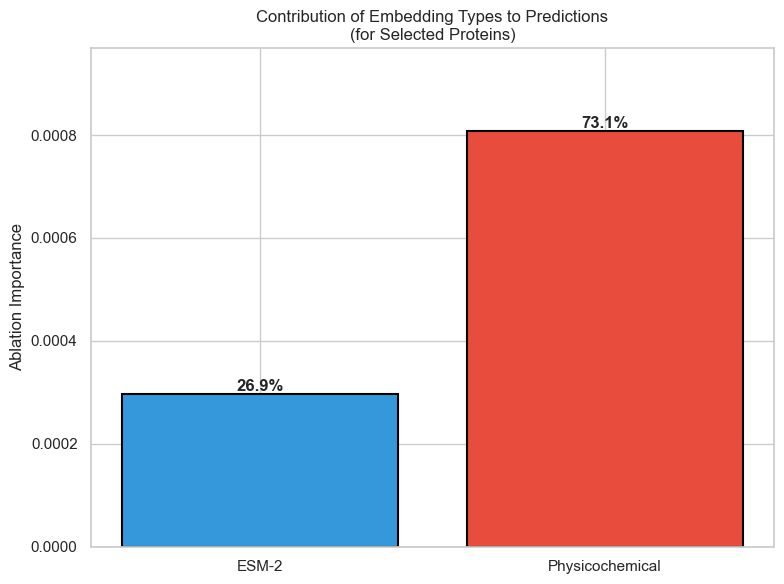

In [66]:
# Visualise contribution
fig, ax = plt.subplots(figsize=(8, 6))

names = list(group_importance.keys())
values = list(group_importance.values())
colors = ['#3498db', '#e74c3c']

bars = ax.bar(names, values, color=colors, edgecolor='black', linewidth=1.5)

# Add percentage labels
total = sum(values)
for bar, value in zip(bars, values):
    height = bar.get_height()
    pct = (value / total) * 100 if total > 0 else 0
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel("Ablation Importance")
ax.set_title("Contribution of Embedding Types to Predictions\n(for Selected Proteins)")
ax.set_ylim(0, max(values) * 1.2)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "embedding_type_contribution.png")
plt.show()

### 8.4 Understanding Why Proteins Were Selected

Compare feature attributions between selected and unselected proteins.

In [67]:
# Get attributions for unselected proteins (sample)
unselected_idx = np.array([i for i in range(len(pool_data["ids"])) 
                           if i not in selection_result.selected_indices])
unselected_sample_idx = np.random.choice(unselected_idx, size=min(15, len(unselected_idx)), replace=False)
unselected_embeddings = torch.from_numpy(
    pool_data["embeddings"][unselected_sample_idx]
).float()

# Compute importance for both groups
selected_importance = interpreter.feature_importance(
    selected_embeddings, task="cell_painting", aggregate="mean"
)
unselected_importance = interpreter.feature_importance(
    unselected_embeddings, task="cell_painting", aggregate="mean"
)

# Compare
importance_diff = selected_importance - unselected_importance

print("Comparison of feature importance: Selected vs Unselected")
print("-" * 60)

# Features more important for selected proteins
more_important_for_selected = np.argsort(importance_diff)[-10:][::-1]
print("\nFeatures MORE important for selected proteins:")
for feat_idx in more_important_for_selected:
    print(f"  Feature {feat_idx}: diff = +{importance_diff[feat_idx]:.4f}")

# Features more important for unselected proteins
more_important_for_unselected = np.argsort(importance_diff)[:10]
print("\nFeatures MORE important for unselected proteins:")
for feat_idx in more_important_for_unselected:
    print(f"  Feature {feat_idx}: diff = {importance_diff[feat_idx]:.4f}")

Comparison of feature importance: Selected vs Unselected
------------------------------------------------------------

Features MORE important for selected proteins:
  Feature 1482: diff = +0.0579
  Feature 37: diff = +0.0574
  Feature 1570: diff = +0.0551
  Feature 1504: diff = +0.0499
  Feature 779: diff = +0.0499
  Feature 338: diff = +0.0489
  Feature 956: diff = +0.0465
  Feature 1364: diff = +0.0454
  Feature 1380: diff = +0.0451
  Feature 564: diff = +0.0437

Features MORE important for unselected proteins:
  Feature 1714: diff = -0.0546
  Feature 602: diff = -0.0530
  Feature 130: diff = -0.0484
  Feature 1422: diff = -0.0451
  Feature 1058: diff = -0.0439
  Feature 934: diff = -0.0431
  Feature 1492: diff = -0.0429
  Feature 96: diff = -0.0429
  Feature 1019: diff = -0.0415
  Feature 427: diff = -0.0408


2026-02-15 23:48:11 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\feature_importance_plots.png


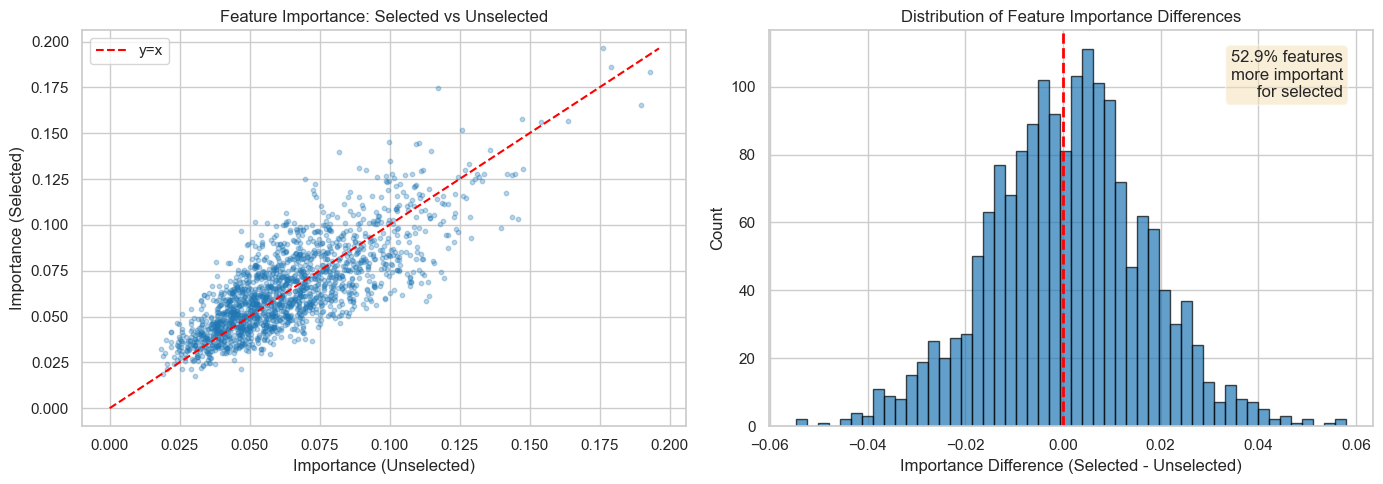

In [68]:
# Visualise the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter of importance values
ax = axes[0]
ax.scatter(unselected_importance, selected_importance, alpha=0.3, s=10)
ax.plot([0, max(selected_importance.max(), unselected_importance.max())],
        [0, max(selected_importance.max(), unselected_importance.max())],
        'r--', label='y=x')
ax.set_xlabel("Importance (Unselected)")
ax.set_ylabel("Importance (Selected)")
ax.set_title("Feature Importance: Selected vs Unselected")
ax.legend()

# Plot 2: Difference distribution
ax = axes[1]
ax.hist(importance_diff, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel("Importance Difference (Selected - Unselected)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Feature Importance Differences")

# Add annotations
positive_pct = (importance_diff > 0).mean() * 100
ax.text(0.95, 0.95, f'{positive_pct:.1f}% features\nmore important\nfor selected',
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "feature_importance_plots.png")
plt.show()

## 9. Visualisation

Let's create comprehensive visualisations of the active learning process.

### 9.1 Uncertainty Distributions

2026-02-15 23:48:11 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\uncertainty_distribution_selected_samples.png


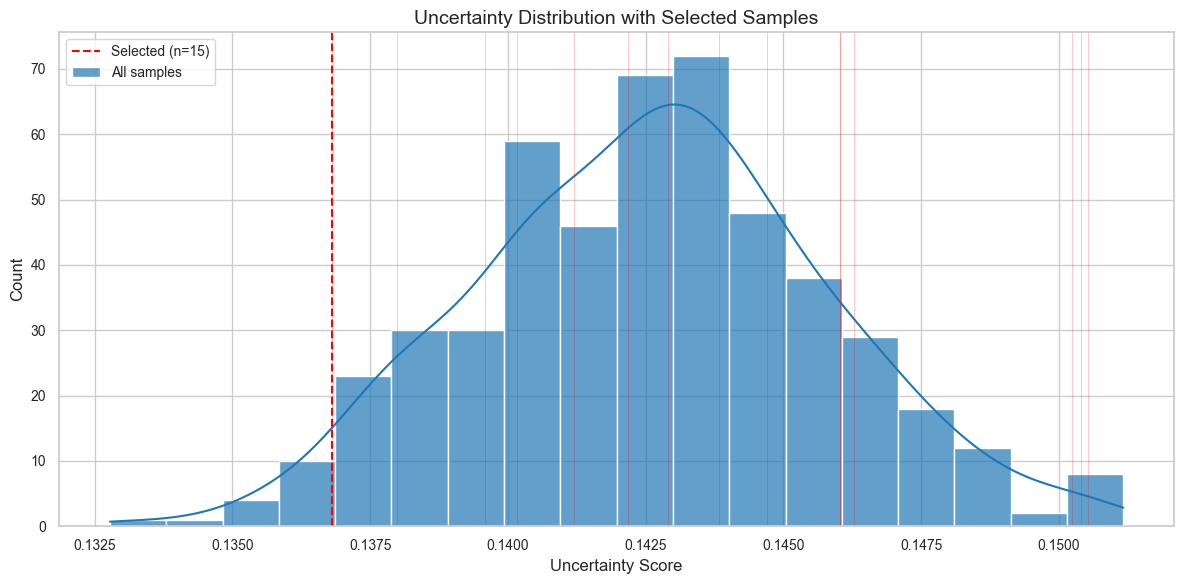

In [69]:
# Plot uncertainty distribution with selected samples highlighted
fig, ax = plot_uncertainty_distribution(
    uncertainty_scores=epistemic_per_sample,
    selected_indices=selection_result.selected_indices,
    title="Uncertainty Distribution with Selected Samples",
    figsize=(12, 6),
)
save_figure(fig, FIGURES_DIR / "uncertainty_distribution_selected_samples.png")
plt.show()

2026-02-15 23:48:12 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\selected_samples_uncertainty_by_strategy.png


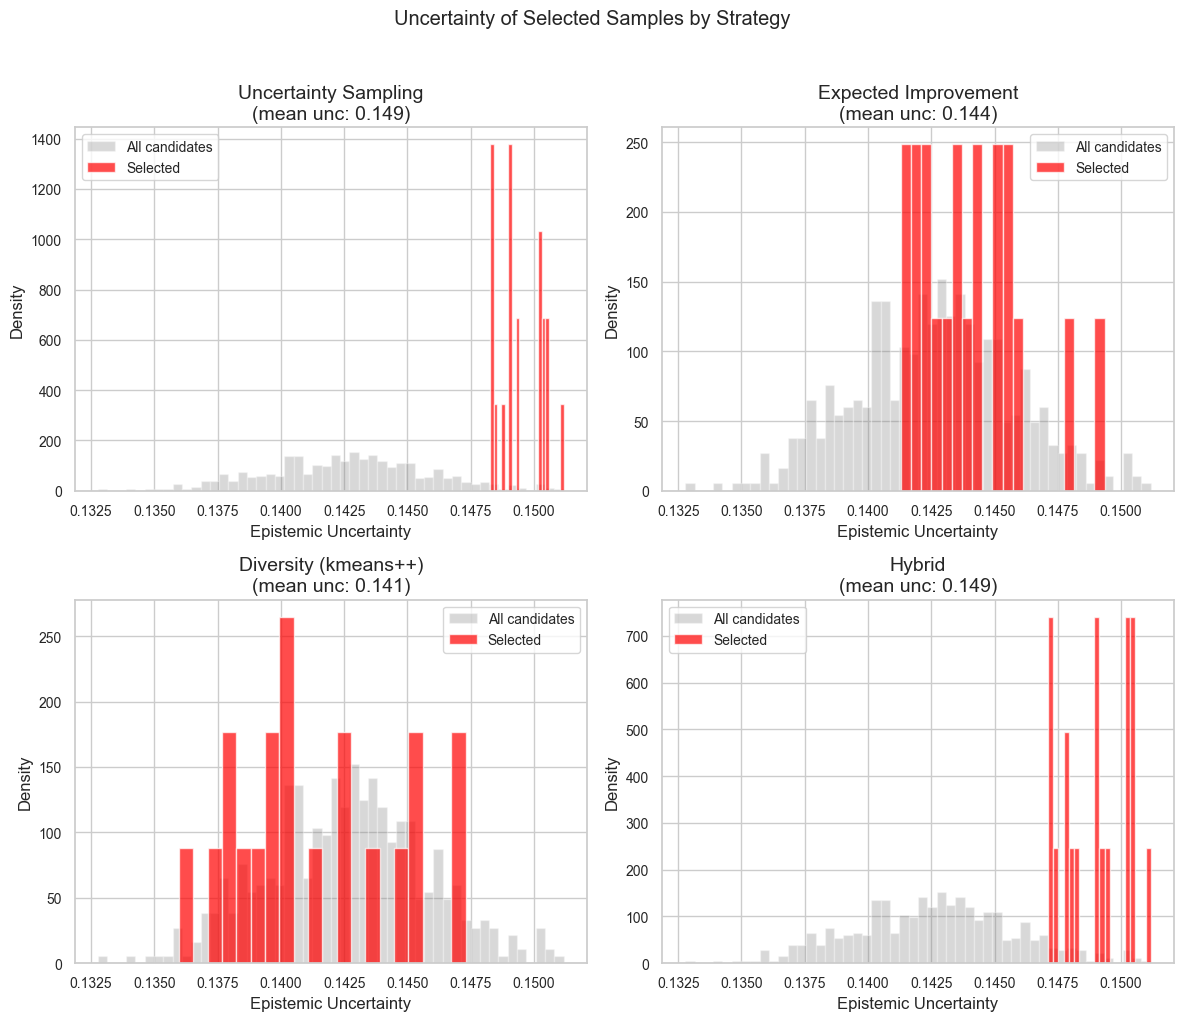

In [70]:
# Compare uncertainty distributions across acquisition strategies
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

strategies_to_plot = {
    "Uncertainty Sampling": uncertainty_selected,
    "Expected Improvement": ei_selected,
    "Diversity (kmeans++)": diversity_results["kmeans++"],
    "Hybrid": hybrid_selected,
}

for ax, (name, indices) in zip(axes.flatten(), strategies_to_plot.items()):
    # Background distribution
    ax.hist(epistemic_per_sample, bins=50, alpha=0.3, color='gray', 
            label='All candidates', density=True)
    
    # Selected distribution
    selected_unc = epistemic_per_sample[indices]
    ax.hist(selected_unc, bins=20, alpha=0.7, color='red',
            label='Selected', density=True)
    
    ax.set_xlabel("Epistemic Uncertainty")
    ax.set_ylabel("Density")
    ax.set_title(f"{name}\n(mean unc: {selected_unc.mean():.3f})")
    ax.legend()

plt.suptitle("Uncertainty of Selected Samples by Strategy", y=1.02)
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "selected_samples_uncertainty_by_strategy.png")
plt.show()

### 9.2 Selected vs Unselected in Embedding Space

2026-02-15 23:48:29 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\selected_unselected_pca.png


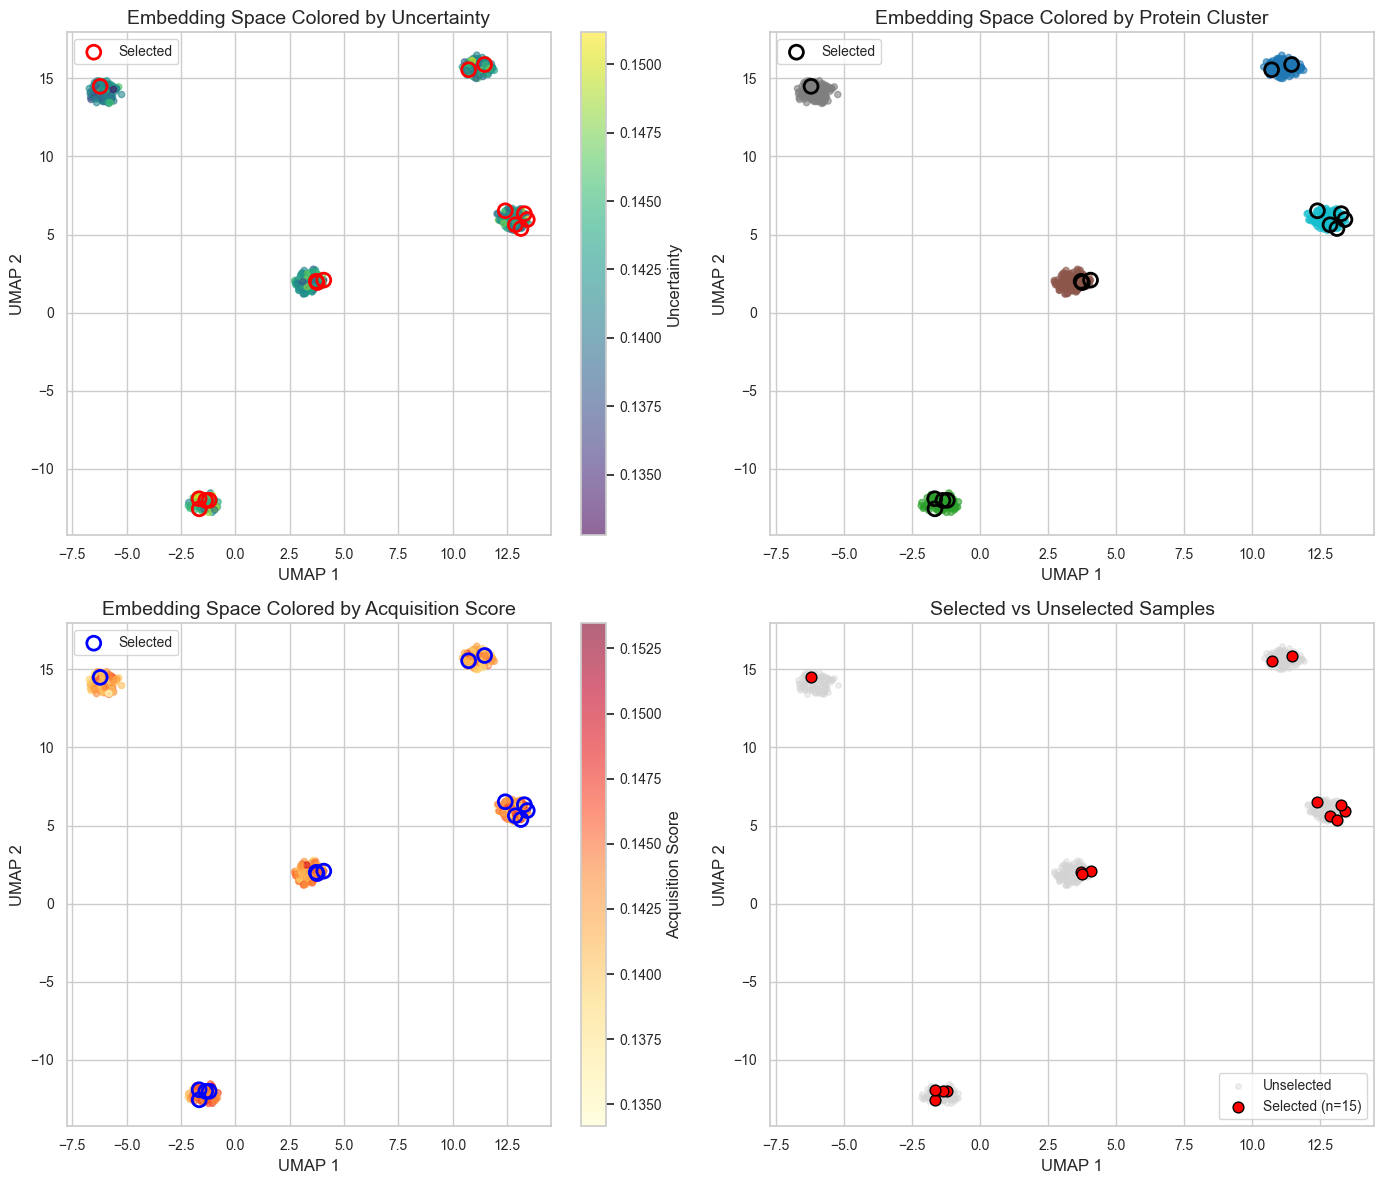

In [71]:
# Create comprehensive embedding space visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Reduce dimensions using UMAP for better visualisation
try:
    from umap import UMAP
    reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    embeddings_umap = reducer.fit_transform(pool_data["embeddings"])
    dim_red_name = "UMAP"
except ImportError:
    # Fall back to PCA
    embeddings_umap = embeddings_2d
    dim_red_name = "PCA"

# Plot 1: Colored by uncertainty
ax = axes[0, 0]
scatter = ax.scatter(
    embeddings_umap[:, 0], embeddings_umap[:, 1],
    c=epistemic_per_sample, cmap='viridis', alpha=0.6, s=20
)
plt.colorbar(scatter, ax=ax, label='Uncertainty')
ax.scatter(
    embeddings_umap[selection_result.selected_indices, 0],
    embeddings_umap[selection_result.selected_indices, 1],
    facecolors='none', edgecolors='red', s=100, linewidths=2,
    label='Selected'
)
ax.set_xlabel(f"{dim_red_name} 1")
ax.set_ylabel(f"{dim_red_name} 2")
ax.set_title("Embedding Space Colored by Uncertainty")
ax.legend()

# Plot 2: Colored by cluster
ax = axes[0, 1]
scatter = ax.scatter(
    embeddings_umap[:, 0], embeddings_umap[:, 1],
    c=pool_data["clusters"], cmap='tab10', alpha=0.6, s=20
)
ax.scatter(
    embeddings_umap[selection_result.selected_indices, 0],
    embeddings_umap[selection_result.selected_indices, 1],
    facecolors='none', edgecolors='black', s=100, linewidths=2,
    label='Selected'
)
ax.set_xlabel(f"{dim_red_name} 1")
ax.set_ylabel(f"{dim_red_name} 2")
ax.set_title("Embedding Space Colored by Protein Cluster")
ax.legend()

# Plot 3: Colored by acquisition score
ax = axes[1, 0]
scatter = ax.scatter(
    embeddings_umap[:, 0], embeddings_umap[:, 1],
    c=selection_result.all_scores, cmap='YlOrRd', alpha=0.6, s=20
)
plt.colorbar(scatter, ax=ax, label='Acquisition Score')
ax.scatter(
    embeddings_umap[selection_result.selected_indices, 0],
    embeddings_umap[selection_result.selected_indices, 1],
    facecolors='none', edgecolors='blue', s=100, linewidths=2,
    label='Selected'
)
ax.set_xlabel(f"{dim_red_name} 1")
ax.set_ylabel(f"{dim_red_name} 2")
ax.set_title("Embedding Space Colored by Acquisition Score")
ax.legend()

# Plot 4: Selected vs unselected
ax = axes[1, 1]
unselected_mask = np.ones(len(pool_data["ids"]), dtype=bool)
unselected_mask[selection_result.selected_indices] = False

ax.scatter(
    embeddings_umap[unselected_mask, 0], embeddings_umap[unselected_mask, 1],
    c='lightgray', alpha=0.4, s=15, label='Unselected'
)
ax.scatter(
    embeddings_umap[selection_result.selected_indices, 0],
    embeddings_umap[selection_result.selected_indices, 1],
    c='red', s=60, edgecolors='black', linewidths=1,
    label=f'Selected (n={len(selection_result.selected_indices)})'
)
ax.set_xlabel(f"{dim_red_name} 1")
ax.set_ylabel(f"{dim_red_name} 2")
ax.set_title("Selected vs Unselected Samples")
ax.legend()

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "selected_unselected_pca.png")
plt.show()

### 9.3 Active Learning Progress Curves

2026-02-15 23:48:30 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\AL_progress_analysis.png


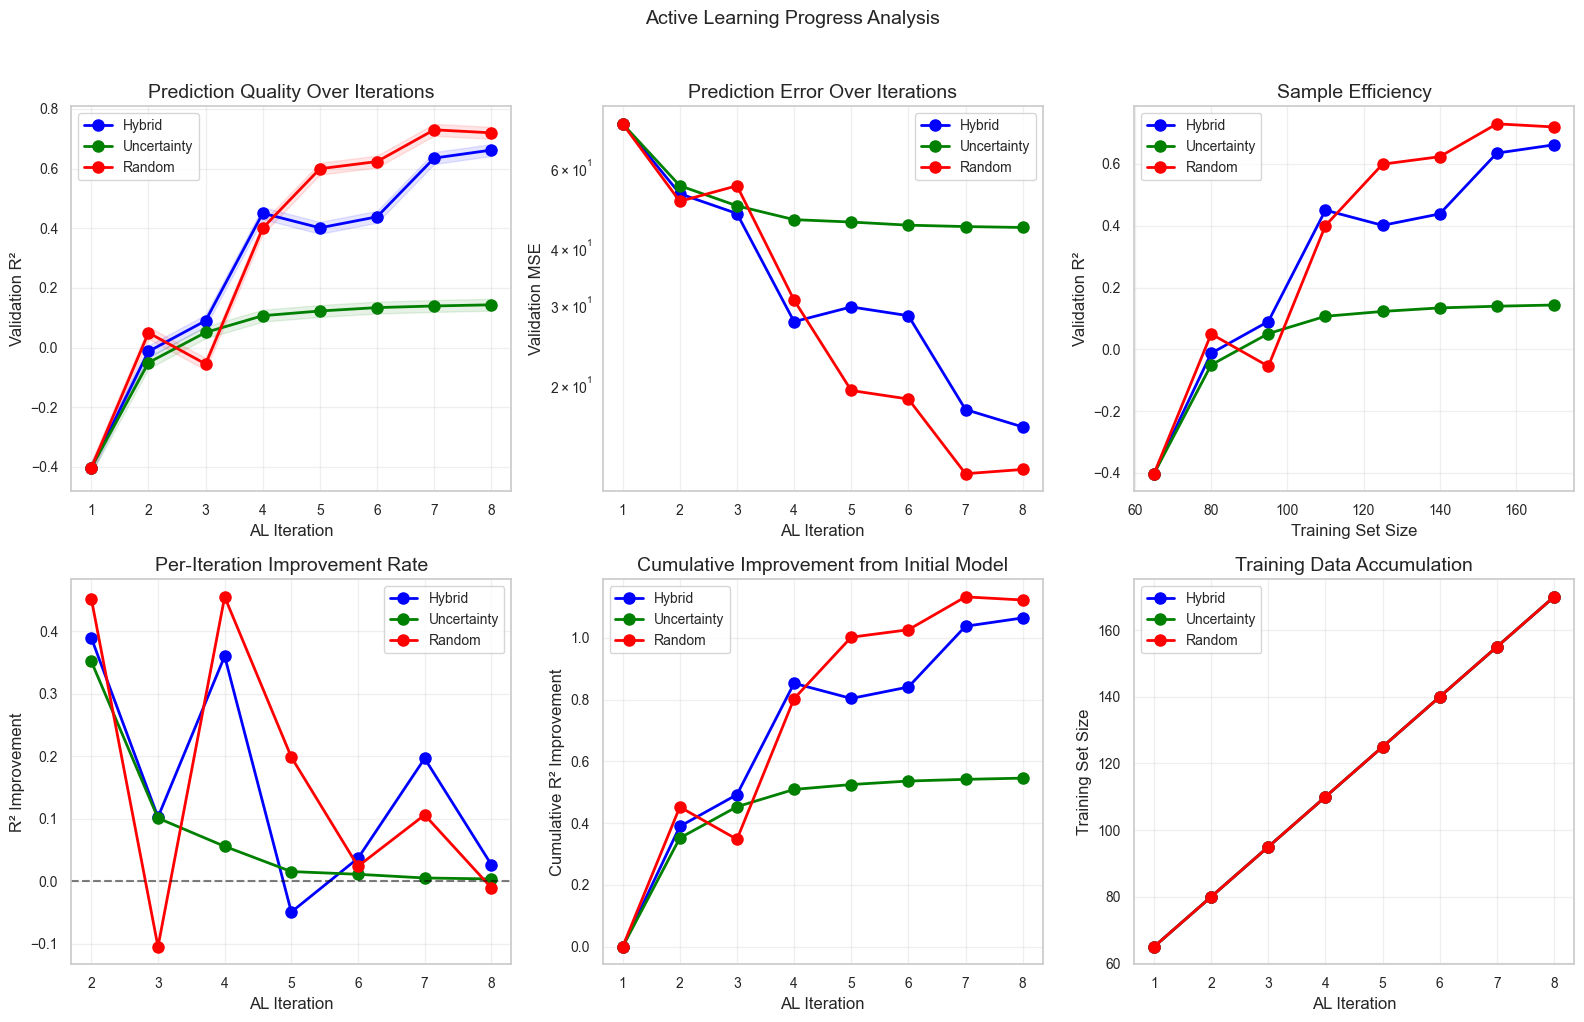

In [72]:
# Comprehensive progress visualisation
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: R² improvement
ax = axes[0, 0]
for name, history, color in [
    ("Hybrid", al_history_hybrid, "blue"),
    ("Uncertainty", al_history_uncertainty, "green"),
    ("Random", al_history_random, "red"),
]:
    ax.plot(history["iteration"], history["val_r2"], 
            'o-', linewidth=2, markersize=8, label=name, color=color)
    ax.fill_between(history["iteration"], 
                    np.array(history["val_r2"]) - 0.02,
                    np.array(history["val_r2"]) + 0.02,
                    alpha=0.1, color=color)
ax.set_xlabel("AL Iteration")
ax.set_ylabel("Validation R²")
ax.set_title("Prediction Quality Over Iterations")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: MSE reduction
ax = axes[0, 1]
for name, history, color in [
    ("Hybrid", al_history_hybrid, "blue"),
    ("Uncertainty", al_history_uncertainty, "green"),
    ("Random", al_history_random, "red"),
]:
    ax.plot(history["iteration"], history["val_mse"],
            'o-', linewidth=2, markersize=8, label=name, color=color)
ax.set_xlabel("AL Iteration")
ax.set_ylabel("Validation MSE")
ax.set_title("Prediction Error Over Iterations")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 3: Sample efficiency
ax = axes[0, 2]
for name, history, color in [
    ("Hybrid", al_history_hybrid, "blue"),
    ("Uncertainty", al_history_uncertainty, "green"),
    ("Random", al_history_random, "red"),
]:
    ax.plot(history["train_size"], history["val_r2"],
            'o-', linewidth=2, markersize=8, label=name, color=color)
ax.set_xlabel("Training Set Size")
ax.set_ylabel("Validation R²")
ax.set_title("Sample Efficiency")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: R² improvement rate
ax = axes[1, 0]
for name, history, color in [
    ("Hybrid", al_history_hybrid, "blue"),
    ("Uncertainty", al_history_uncertainty, "green"),
    ("Random", al_history_random, "red"),
]:
    r2_values = np.array(history["val_r2"])
    improvement_rate = np.diff(r2_values)
    ax.plot(history["iteration"][1:], improvement_rate,
            'o-', linewidth=2, markersize=8, label=name, color=color)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel("AL Iteration")
ax.set_ylabel("R² Improvement")
ax.set_title("Per-Iteration Improvement Rate")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: Cumulative improvement
ax = axes[1, 1]
for name, history, color in [
    ("Hybrid", al_history_hybrid, "blue"),
    ("Uncertainty", al_history_uncertainty, "green"),
    ("Random", al_history_random, "red"),
]:
    r2_values = np.array(history["val_r2"])
    cumulative_improvement = r2_values - r2_values[0]
    ax.plot(history["iteration"], cumulative_improvement,
            'o-', linewidth=2, markersize=8, label=name, color=color)
ax.set_xlabel("AL Iteration")
ax.set_ylabel("Cumulative R² Improvement")
ax.set_title("Cumulative Improvement from Initial Model")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: Training set growth
ax = axes[1, 2]
for name, history, color in [
    ("Hybrid", al_history_hybrid, "blue"),
    ("Uncertainty", al_history_uncertainty, "green"),
    ("Random", al_history_random, "red"),
]:
    ax.plot(history["iteration"], history["train_size"],
            'o-', linewidth=2, markersize=8, label=name, color=color)
ax.set_xlabel("AL Iteration")
ax.set_ylabel("Training Set Size")
ax.set_title("Training Data Accumulation")
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle("Active Learning Progress Analysis", y=1.02, fontsize=14)
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "AL_progress_analysis.png")
plt.show()

2026-02-15 23:48:31 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\selected_samples_by_protein_cluster_heatmap.png


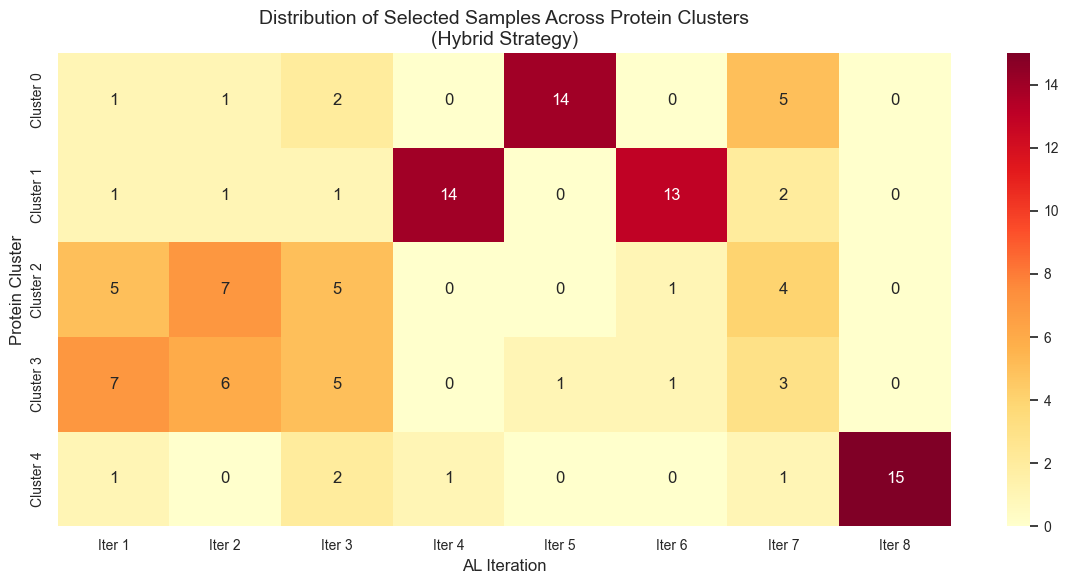

In [73]:
# Create summary heatmap of selections across iterations
fig, ax = plt.subplots(figsize=(12, 6))

# Get cluster distribution of selections per iteration for hybrid
cluster_selections = np.zeros((len(al_history_hybrid["iteration"]), 5))  # 5 clusters

for i, selected_ids in enumerate(al_history_hybrid["selected_ids"]):
    # Map selected IDs back to cluster assignments
    id_to_idx = {pid: idx for idx, pid in enumerate(sim_pool_data["ids"])}
    for sid in selected_ids:
        if sid in id_to_idx:
            cluster = sim_pool_data["clusters"][id_to_idx[sid]]
            cluster_selections[i, cluster] += 1

sns.heatmap(cluster_selections.T, annot=True, fmt=".0f", cmap="YlOrRd",
            xticklabels=[f"Iter {i+1}" for i in range(len(al_history_hybrid["iteration"]))],
            yticklabels=[f"Cluster {i}" for i in range(5)],
            ax=ax)
ax.set_xlabel("AL Iteration")
ax.set_ylabel("Protein Cluster")
ax.set_title("Distribution of Selected Samples Across Protein Clusters\n(Hybrid Strategy)")

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "selected_samples_by_protein_cluster_heatmap.png")
plt.show()

## 10. Practical Considerations

### 10.1 Batch Size for Wet-Lab Experiments

The optimal batch size depends on several factors:

1. **Wet-Lab Throughput**
   - Cell Painting: ~384-1536 wells per plate
   - Typical batch: 96-384 proteins per round
   
2. **Model Uncertainty Decay**
   - Larger batches lead to faster uncertainty reduction
   - **But**: diminishing returns within a batch

3. **Recommendation**
   - Start with smaller batches (10-50) to validate pipeline
   - Scale to 96-384 for production runs
   - Consider plate layout constraints

2026-02-15 23:48:32 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\batch_size_vs_info_gain.png


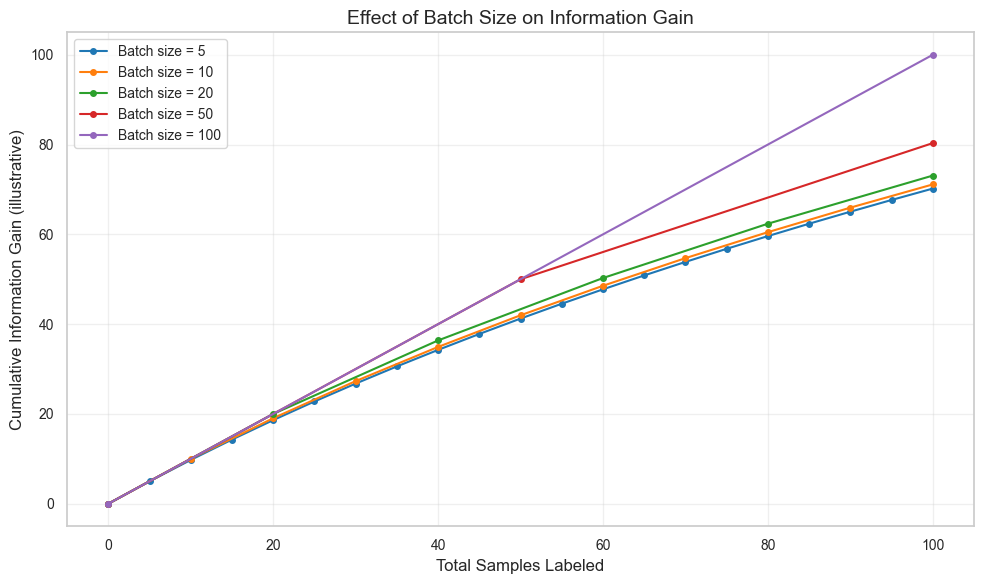

In [74]:
# Simulate effect of batch size
batch_sizes = [5, 10, 20, 50, 100]
iterations_per_budget = [100 // bs for bs in batch_sizes]

fig, ax = plt.subplots(figsize=(10, 6))

# This is illustrative - in practice you'd run simulations
# Assume diminishing returns: each sample adds less information
cumulative_info = []
for bs, n_iter in zip(batch_sizes, iterations_per_budget):
    info = 0
    info_history = [0]
    for i in range(n_iter):
        # Simplified model: info gain decreases as we add more data
        batch_info = bs * np.exp(-info * 0.01)
        info += batch_info
        info_history.append(info)
    cumulative_info.append((bs, info_history))

for bs, info_history in cumulative_info:
    samples_seen = [i * bs for i in range(len(info_history))]
    ax.plot(samples_seen, info_history, 'o-', label=f'Batch size = {bs}', markersize=4)

ax.set_xlabel("Total Samples Labeled")
ax.set_ylabel("Cumulative Information Gain (illustrative)")
ax.set_title("Effect of Batch Size on Information Gain")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "batch_size_vs_info_gain.png")
plt.show()

### 10.2 Balancing Exploration vs Exploitation

The explore-exploit balance should change over time:

**Early stages (iterations 1-3):**
- Prioritise **exploration**
- High uncertainty weight (0.8-1.0)
- Goal: Learn the landscape
- Recommended: Pure uncertainty sampling or diversity

**Middle stages (iterations 4-7):**
- **Balanced** approach
- Hybrid acquisition (0.5-0.7 uncertainty, 0.3-0.5 diversity)
- Goal: Refine model while maintaining coverage

**Late stages (iterations 8+):**
- Prioritise **exploitation**
- Expected Improvement or UCB
- Goal: Optimise for desired phenotypes
- Consider target-specific acquisition

2026-02-15 23:48:32 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\04_active_learning\figures\explore_exploit.png


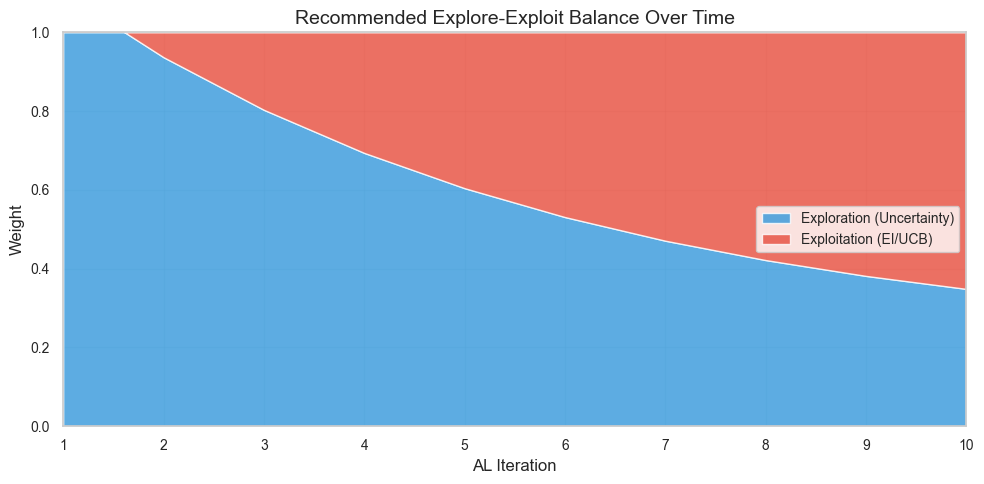

In [75]:
# Visualise recommended weights over iterations
iterations = np.arange(1, 11)
exploration_weight = 0.9 * np.exp(-0.2 * (iterations - 1)) + 0.2
exploitation_weight = 1 - exploration_weight

fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(iterations, exploration_weight, exploitation_weight,
             labels=['Exploration (Uncertainty)', 'Exploitation (EI/UCB)'],
             colors=['#3498db', '#e74c3c'], alpha=0.8)
ax.set_xlabel("AL Iteration")
ax.set_ylabel("Weight")
ax.set_title("Recommended Explore-Exploit Balance Over Time")
ax.legend(loc='center right')
ax.set_xlim(1, 10)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
plt.tight_layout()
save_figure(fig, FIGURES_DIR / "explore_exploit.png")
plt.show()

### 10.3 When to Stop Active Learning

In [76]:
print("Stopping Criteria for Active Learning")
print("=" * 60)

print("""
Consider stopping when:

1. **Performance Plateau**
   - Validation R² improvement < 0.01 for 2+ iterations
   - Test uncertainty stops decreasing
   
2. **Budget Exhaustion**
   - Fixed experimental budget reached
   - Time constraints
   
3. **Sufficient Coverage**
   - All protein clusters represented
   - Design space well-explored
   
4. **Uncertainty Threshold**
   - Max uncertainty < acceptable threshold
   - Model confident on all candidates

5. **Diminishing Returns**
   - Information gain per sample too low
   - AULC improvement minimal
""")

Stopping Criteria for Active Learning

Consider stopping when:

1. **Performance Plateau**
   - Validation R² improvement < 0.01 for 2+ iterations
   - Test uncertainty stops decreasing

2. **Budget Exhaustion**
   - Fixed experimental budget reached
   - Time constraints

3. **Sufficient Coverage**
   - All protein clusters represented
   - Design space well-explored

4. **Uncertainty Threshold**
   - Max uncertainty < acceptable threshold
   - Model confident on all candidates

5. **Diminishing Returns**
   - Information gain per sample too low
   - AULC improvement minimal



In [77]:
# Demonstrate stopping criteria evaluation
def evaluate_stopping_criteria(history: Dict) -> Dict[str, bool]:
    """Evaluate various stopping criteria."""
    criteria = {}
    
    # 1. Performance plateau
    r2_values = np.array(history["val_r2"])
    if len(r2_values) >= 3:
        recent_improvement = r2_values[-1] - r2_values[-3]
        criteria["performance_plateau"] = recent_improvement < 0.02
    else:
        criteria["performance_plateau"] = False
    
    # 2. Diminishing returns
    if len(r2_values) >= 2:
        improvements = np.diff(r2_values)
        criteria["diminishing_returns"] = improvements[-1] < 0.005
    else:
        criteria["diminishing_returns"] = False
    
    # 3. Training size threshold (example: 200 samples)
    criteria["size_threshold"] = history["train_size"][-1] >= 200
    
    return criteria


print("\nStopping Criteria Evaluation (Hybrid Strategy):")
print("-" * 50)
stopping_eval = evaluate_stopping_criteria(al_history_hybrid)
for criterion, triggered in stopping_eval.items():
    status = "  TRIGGERED" if triggered else "  Not triggered"
    print(f"  {criterion}: {status}")


Stopping Criteria Evaluation (Hybrid Strategy):
--------------------------------------------------
  performance_plateau:   Not triggered
  diminishing_returns:   Not triggered
  size_threshold:   Not triggered


In [78]:
## Data exports
# Save active learning results
import json

# Save selection results
selection_result.to_dict()  # already exists
with open(DATA_DIR / "final_selection.json", "w") as f:
    json.dump(selection_result.to_dict(), f, indent=2, default=str)

# Save AL simulation history
for name, history in [("hybrid", al_history_hybrid), 
                       ("uncertainty", al_history_uncertainty),
                       ("random", al_history_random)]:
    # Convert numpy arrays to lists for JSON serialization
    serializable = {k: (v.tolist() if isinstance(v, np.ndarray) else v) 
                    for k, v in history.items()}
    with open(DATA_DIR / f"al_history_{name}.json", "w") as f:
        json.dump(serializable, f, indent=2, default=str)

print(f"Results saved to {DATA_DIR}")

Results saved to outputs\04_active_learning\results


## 11. Summary & Conclusion

### Key Takeaways


#### **Active Learning Summary**

1. **Uncertainty Quantification**
    • MC Dropout: Simple, effective, single model
    • Ensembles: Better calibrated, higher cost
    • Heteroscedastic: Captures aleatoric uncertainty

2. **Acquisition Functions**
    • Uncertainty Sampling: Pure exploration
    • Expected Improvement: Balanced (recommended for optimisation)
    • Diversity Sampling: Coverage-focused
    • Hybrid: Best for batch selection (uncertainty + diversity)

3. **Key Findings from Simulation**
    • Active learning outperforms random selection
    • Hybrid strategy provides best sample efficiency
    • Early iterations show largest gains

4. **Practical Recommendations**
    • Use MC Dropout (n=20) for single-model uncertainty
    • Start with hybrid acquisition (0.7 unc, 0.3 div)
    • Batch size: 10-50 for validation, 96-384 for production
    • Monitor validation R² and stop when consistent plateau occurs (i.e., patience and early stopping)

In [79]:
# Final summary statistics
print("\nSimulation Results Summary")
print("=" * 60)

final_summary = pd.DataFrame({
    "Metric": ["Initial R²", "Final R²", "Improvement", "Final MSE", "Samples Used"],
    "Hybrid": [
        f"{al_history_hybrid['val_r2'][0]:.4f}",
        f"{al_history_hybrid['val_r2'][-1]:.4f}",
        f"{al_history_hybrid['val_r2'][-1] - al_history_hybrid['val_r2'][0]:.4f}",
        f"{al_history_hybrid['val_mse'][-1]:.4f}",
        f"{al_history_hybrid['train_size'][-1]}",
    ],
    "Uncertainty": [
        f"{al_history_uncertainty['val_r2'][0]:.4f}",
        f"{al_history_uncertainty['val_r2'][-1]:.4f}",
        f"{al_history_uncertainty['val_r2'][-1] - al_history_uncertainty['val_r2'][0]:.4f}",
        f"{al_history_uncertainty['val_mse'][-1]:.4f}",
        f"{al_history_uncertainty['train_size'][-1]}",
    ],
    "Random": [
        f"{al_history_random['val_r2'][0]:.4f}",
        f"{al_history_random['val_r2'][-1]:.4f}",
        f"{al_history_random['val_r2'][-1] - al_history_random['val_r2'][0]:.4f}",
        f"{al_history_random['val_mse'][-1]:.4f}",
        f"{al_history_random['train_size'][-1]}",
    ],
})

print(final_summary.to_string(index=False))


Simulation Results Summary
      Metric  Hybrid Uncertainty  Random
  Initial R² -0.4023     -0.4023 -0.4025
    Final R²  0.6620      0.1435  0.7198
 Improvement  1.0643      0.5458  1.1224
   Final MSE 16.1627     44.2827 13.0370
Samples Used     170         170     170


### Next Steps

After completing this notebook, you should:

1. **Apply to Real Data**: Replace synthetic data with your actual protein
   embeddings and experimental results

2. **Integrate with Wet-Lab**: Set up the feedback loop with your experimental
   collaborators

3. **Monitor and Adapt**: Track model performance and adjust acquisition
   strategy as needed

4. **Scale Up**: Once validated, increase batch sizes for production runs

### Related Notebooks

- `01_protein_embeddings.ipynb`: Extract protein embeddings
- `02_phenotype_exploration.ipynb`: Explore phenotype data
- `03_model_training.ipynb`: Train the ProToPhen model
- `05_deployment.ipynb` (future): Deploy for production use

In [80]:
print("=" * 60)
print(f"\nTotal proteins in pool: {len(pool_data['ids'])}")
print(f"Total selections made: {len(selector.config.exclude_ids)}")
print(f"Remaining candidates: {len(pool_data['ids']) - len(selector.config.exclude_ids)}")
print("\nReady for wet-lab validation!")


Total proteins in pool: 500
Total selections made: 30
Remaining candidates: 470

Ready for wet-lab validation!
